In [689]:
import pandas as pd
from unidecode import unidecode
import re
import warnings
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
test_data = pd.read_csv('test_x.csv')
from sklearn.preprocessing import OrdinalEncoder

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
df_data=pd.read_csv("train.csv")
il_ilce=pd.read_csv("il_ilce.csv")

In [690]:
il_ilce= il_ilce.apply(lambda col: col.astype(str).str.lower().apply(unidecode) if col.dtype == 'object' else col)

In [691]:
df_data = df_data.apply(lambda col: col.astype(str).str.lower().apply(unidecode) if col.dtype == 'object' else col)
test_data = test_data.apply(lambda col: col.astype(str).str.lower().apply(unidecode) if col.dtype == 'object' else col)

In [692]:
df_data["Lise Mezuniyet Notu"].replace('3.50-3', "75 - 100",inplace=True)
df_data["Lise Mezuniyet Notu"].replace("3.00 - 4.00","75 - 100", inplace=True)
df_data["Lise Mezuniyet Notu"].replace('3.00-2.50', "50 - 74",inplace=True)
df_data["Lise Mezuniyet Notu"].replace("2.50 ve alti","25 - 49", inplace=True)
df_data["Lise Mezuniyet Notu"].replace("4.00-3.50","75 - 100", inplace=True)
df_data["Lise Mezuniyet Notu"].replace("3.50-3.00","75 - 100", inplace=True)
df_data["Lise Mezuniyet Notu"].replace("69-55","50 - 74", inplace=True)
df_data["Lise Mezuniyet Notu"].replace("100-85","75 - 100", inplace=True)
df_data["Lise Mezuniyet Notu"].replace("84-70","75 - 100", inplace=True)
df_data["Lise Mezuniyet Notu"].replace("54-45","50 - 74", inplace=True)
df_data["Lise Mezuniyet Notu"].replace("44-0","25 - 49", inplace=True)
df_data["Lise Mezuniyet Notu"].replace("not ortalamasi yok",0, inplace=True)
df_data["Lise Mezuniyet Notu"].replace("0 - 25",0, inplace=True)
df_data["Lise Mezuniyet Notu"].replace("0 - 24",0, inplace=True)
df_data["Lise Mezuniyet Notu"].replace(np.nan, 0, inplace=True)

maplisenot = {
    "25 - 49": 1,
    "50 - 74": 2,
    "75 - 100": 3,
}
df_data["Lise Mezuniyet Notu"] = df_data["Lise Mezuniyet Notu"].map(maplisenot)
test_data["Lise Mezuniyet Notu"] = test_data["Lise Mezuniyet Notu"].map(maplisenot)
df_data["Lise Mezuniyet Notu"].fillna(0, inplace=True)

In [693]:
dropcols=pd.Series([
        "Daha Once Baska Bir Universiteden Mezun Olmus","Lise Adi Diger","Burslu ise Burs Yuzdesi",
        "Lise Bolum Diger","Uye Oldugunuz Kulubun Ismi","Stk Projesine Katildiniz Mi?","Ingilizce Seviyeniz?",
        "Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite","Lise Adi",
       "id","Baska Bir Kurumdan Burs Aliyor mu?"
])

In [694]:
df_data=df_data.drop(dropcols,axis=1)
test_data=test_data.drop(dropcols,axis=1)
df_data=df_data.replace("nan",np.nan)

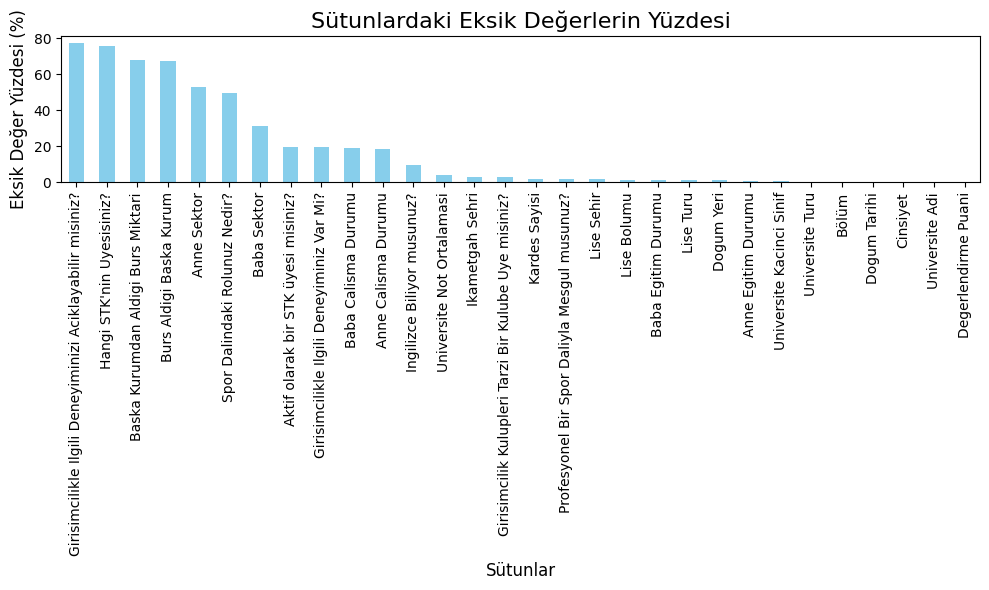

In [695]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_missing_values(df):
    # Her sütundaki eksik veri yüzdesini hesapla
    missing_percentages = df.isna().mean() * 100

    # Yalnızca eksik veri içeren sütunları seç
    missing_percentages = missing_percentages[missing_percentages > 0]

    # Eksik veri yüzdelerine göre sıralama
    missing_percentages = missing_percentages.sort_values(ascending=False)

    # Grafik oluşturma
    plt.figure(figsize=(10, 6))
    missing_percentages.plot(kind='bar', color='skyblue')

    # Grafik detayları
    plt.title('Sütunlardaki Eksik Değerlerin Yüzdesi', fontsize=16)
    plt.xlabel('Sütunlar', fontsize=12)
    plt.ylabel('Eksik Değer Yüzdesi (%)', fontsize=12)
    plt.xticks(rotation=90)  # X eksenindeki etiketlerin dik durması için
    plt.tight_layout()
    plt.show()

# Veri seti üzerinde eksik değer grafiğini çiz
plot_missing_values(df_data)


In [696]:
df_data = df_data.dropna(subset=["Degerlendirme Puani"])
#df_data = df_data.dropna(subset=["Universite Adi"])

In [697]:
column_name = "Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?"

# Boş olmayanları "evet", boş olanları "hayir" yap
df_data[column_name] = df_data[column_name].apply(lambda x: "evet" if pd.notna(x) and x != "" else "hayir")
test_data[column_name] = df_data[column_name].apply(lambda x: "evet" if pd.notna(x) and x != "" else "hayir")


In [698]:
column_name = "Hangi STK'nin Uyesisiniz?"

# Boş olmayanları "evet", boş olanları "hayir" yap
df_data[column_name] = df_data[column_name].apply(lambda x: "evet" if pd.notna(x) and x != "" else "hayir")
test_data[column_name] = df_data[column_name].apply(lambda x: "evet" if pd.notna(x) and x != "" else "hayir")

In [699]:
burs_mapping = {
    np.nan              : "-",
    "300"               : "0 - 499 L",
    '300 tl'            : '0 - 499 L',
    '150 tl'            : '0 - 499 L',
    '430tlyilda 10 ay'  : '0 - 499 L',
    '400'               : '0 - 499 L',
    '250 tl'            : '0 - 499 L',
    'toplamda 1000 lira fakat mezun oldugun icin devam etmiyor' : '0 - 499 L',
    '850 tl'            : '0 - 499 L',
    '500 tl'            : '0 - 499 L',
    'aylik 280 tl'      : '0 - 499 L',
    '430'               : '0 - 499 L',
    '1000 tl'           : '1000L ve ustu',
    '900 tl'            : '500L - 999L',
    '300 lira'          : '0 - 499 L',
    '365'               : '0 - 499 L',
    '500tl, 300tl'      :'500L - 999L',
    '125 tl'            : '0 - 499 L',
    '850'               :'500L - 999L',
    '180'               : '0 - 499 L',
    '260'               : '0 - 499 L',
    '425 tl'            : '0 - 499 L',
    'aylik 100 tl'      : '0 - 499 L',
    '300 tl nakit + yemek + ulasim' : '0 - 499 L',
    '300tl'             : '0 - 499 L',
    '250'               :'0 - 499 L', 
    '900'               :'500L - 999L',
    '150'               :'0 - 499 L',
    '400 tl'            :'0 - 499 L',
    '800'               :'500L - 999L',
    '300 tl aylik'      :'0 - 499 L',
    '280'               :'0 - 499 L',
    '400,00 tl'         :'0 - 499 L',
    '200 tl'            :'0 - 499 L',
    '430 tl'            :'0 - 499 L',
    '500 tl - 300 tl'   :'500L - 999L',
    '325 tl'            :'0 - 499 L',
    '300 tl / aylik'    :'0 - 499 L',
    '275 tlaylik'       :'0 - 499 L',
    '10 ay sure ile aylik 600 tl' :'500L - 999L',
    '500 tl ve 300 tl'  :'500L - 999L',
    'bin turk lirasi'   :'1000L ve ustu',
    '475'               :'0 - 499 L',
    '300,0 tl'          :'0 - 499 L',
    '675 tl'            :'500L - 999L',
    'kredi-300' :'0 - 499 L',
    'aylik 300 tl' :'0 - 499 L',
    '300-400' :'0 - 499 L',
    '750' :'500L - 999L',
    '330 tl' :'0 - 499 L',
    'aylik 330 tl' :'0 - 499 L',
    '490' :'0 - 499 L',
    '320 tl' :'0 - 499 L',
    '560 tl' :'500L - 999L',
    'tam burslu oldugum icin yalniz egitim ucreti ek burs almiyorum' :'0 - 499 L',
    '500' :'0 - 499 L',
    '600 tl/yurt bursu/kitap bursu' :'500L - 999L',
    '430tl' :'0 - 499 L',
    '350' :'0 - 499 L',
    '600' :'500L - 999L',
    '8 ay boyunca aylik 720 tl' :'500L - 999L',
    '330' :'0 - 499 L',
    '350 tl - turkiye girisimcilik vakfindan burs kazandigim takdirde celik ihracatcilari birligindeki bursumdan vazgececegim.':'0 - 499 L',
    '150 tl/ay' :'0 - 499 L',
    '100 tl' :'0 - 499 L',
    '300tl nakit + yemek ve yurt bursu' : '0 - 499 L',
    '10 ay suresince 600 tl cep harcligi' :'500L - 999L',
    '590' : '500L - 999L',
    'aylik 490 tl - 9 ay boyunca' : '0 - 499 L',
    '1990' :'1000L ve ustu',
    '475 tl' : '0 - 499 L',
    '560?' :'500L - 999L',
    '600 tl' :'500L - 999L',
    '180 tl' : '0 - 499 L',
    '200' : '0 - 499 L',
    'nakit burslar 700tl, nakde cevrilen yemek ve yol burslariyla 1160' :'1000L ve ustu',
    'ustun basari bursu - 750 tl' :'500L - 999L',
    '560' :'500L - 999L',
    '535' :'500L - 999L',
    'aylik 200 tl' : '0 - 499 L',
    '200 tl/ay' : '0 - 499 L',
    '700 tl' :'500L - 999L',
    '1500' :'1000L ve ustu',
    '600 okul,200 lcw' :'500L - 999L',
    '2000' :'1000L ve ustu',
    '620' :'500L - 999L',
    '175' : '0 - 499 L',
    '325' :'0 - 499 L',
    '570' :'500L - 999L',
    '1200':'1000L ve ustu',
    '1750' :'1000L ve ustu',
    '610' :'500L - 999L',
    '275' :'0 - 499 L',
    '520' :'500L - 999L',
    '460' :'0 - 499 L',
    '515' :'500L - 999L',
    '1100' :'1000L ve ustu',
    '820' :'500L - 999L',
    '815' :'500L - 999L',
    '450' :'0 - 499 L',
    '240' :'0 - 499 L',
    '470':'0 - 499 L',
    '60' :'0 - 499 L',
    '670' :'500L - 999L',
    '315' :'0 - 499 L',
    '480' :'0 - 499 L',
    '650' :'500L - 999L',
    '1000' :'500L - 999L',
    '780' :'500L - 999L',
    '920' :'500L - 999L',
    '300 L' :'0 - 499 L',
    '425' :'0 - 499 L',
    '440':'0 - 499 L',
    '670 turk lirasi' :'500L - 999L',
    '2000 tl' :'1000L ve ustu',
    '1275 tl' :'1000L ve ustu',
    'toplamda 1000' :'1000L ve ustu',
    '750 tl' :'500L - 999L',
    '340':'0 - 499 L',
    '425tl' :'0 - 499 L',
    '660 tl' :'500L - 999L',
    '780, 425' :'1000L ve ustu',
    '380-425' :'500L - 999L',
    '130' :'0 - 499 L',
    '1120try (aylik)':'1000L ve ustu',
    'nakit destek bursu (9 ay sure ile 660 tl)' :'500L - 999L',
    '650 tl' :'500L - 999L',
    '670 tl' :'500L - 999L',
    '420' :'0 - 499 L',
    '375':'0 - 499 L',
    '1275' :'1000L ve ustu',
    'yillik belirlenen kapsamli burs kadar' :'1000L ve ustu',
    '350tl':'0 - 499 L',
    'egitim aylari , her ay 250 tl' :'0 - 499 L',
    '514' :'500L - 999L',
    '225' :'0 - 499 L',
    '100% okul ve 50% yurt bursu':'0 - 499 L',
    '420,geri odemeli' :'0 - 499 L',
    '350 tl' :'0 - 499 L',
    '175 tl' :'0 - 499 L',
    '650tl + 400 tl' :'1000L ve ustu',
    '400, 425':'500L - 999L',
    '1075 toplam' :'1000L ve ustu',
    '9*100' :'0 - 499 L',
    '400tl' :'0 - 499 L',
    '1000.00 tl' :'1000L ve ustu',
    '100' :'0 - 499 L',
    '220' :'0 - 499 L',
    'aylik 400 tl':'0 - 499 L',
    '420 turk lirasi' :'0 - 499 L',
    '2016-2017 yili icinde aylik 400 turk lirasi':'0 - 499 L',
    '400 tl / ay' :'0 - 499 L',
    '424' :'0 - 499 L',
    '425 aylik' :'0 - 499 L',
    '435' :'0 - 499 L',
    'aylik 500 tl' :'0 - 499 L',
    '225 tl' :'0 - 499 L',
    '-':'-',
    '8 ay 1000 tl' :'1000L ve ustu',
    '350-400' :'0 - 499 L',
    'toplam 640 tl' :'500L - 999L',
    '610 tl' :'500L - 999L',
    '3000 tl' :'0 - 499 L',
    '120' :'0 - 499 L',
    '400 L':'0 - 499 L',
    '1200 tl milli sporcu bursu' :'1000L ve ustu',
    'almiyorum henuz' :'-',
    '250 tl/ay':'0 - 499 L',
    '650 tl(yemek bursu)' :'500L - 999L',
    '440 tl' :'0 - 499 L',
    '650tl':'500L - 999L',
    'egitim bursu (%100)' :'0 - 499 L',
    '485 tl':'0 - 499 L',
    '3 ayda bir 600tl' :'500L - 999L',
    '425 L':'0 - 499 L',
    '600 + 400' :'1000L ve ustu',
    '200tl/ay' :'0 - 499 L',
    '425 - 470' :'0 - 499 L',
    '700':'500L - 999L',
    'aylik 650 tl' :'500L - 999L',
    'ilk 1000 bursu' :'1000L ve ustu',
    '2000 + 1275' :'1000L ve ustu',
    '550' :'500L - 999L',
    '1080' :'1000L ve ustu',
    '255' :'0 - 499 L',
    '2700':'1000L ve ustu',
    '320' :'0 - 499 L',
    '665' :'500L - 999L',
    '290' :'0 - 499 L',
    '1250' :'1000L ve ustu',
    '1300' :'1000L ve ustu',
    '14500' :'500L - 999L',
    '2200' :'1000L ve ustu',
    '125' :'0 - 499 L',
    '0' :'0 - 499 L',
    '970' :'500L - 999L',
    '2300':'1000L ve ustu',
    '525' :'500L - 999L',
    '1600' :'1000L ve ustu',
    '500 ve uzeri' :'500L - 999L',
    '300-500' :'500L - 999L',
    'diger' :'1000L ve ustu',
    '300 t' :'0 - 499 L',
    '75' :'0 - 499 L',
    '423':'0 - 499 L',
    'meslek yuksekokulu okul 2.lik bursu- %75':'0 - 499 L',
    'applybau sistemi tarafindan egitim ucretimin %80' :'0 - 499 L',
    'cince dil bursu':'0 - 499 L',
    'degisiyordu her sene' :'500L - 999L',
    '200 L' :'0 - 499 L',
    '410' :'0 - 499 L',
    '275 tl' :'0 - 499 L',
    '270' :'0 - 499 L',
    '300?' :'0 - 499 L',
    'aylik 620 tl':'500L - 999L',
    '365 tl' :'0 - 499 L',
    '300-geri odemeli' :'0 - 499 L',
    '290 tl' :'0 - 499 L',
    '300 tl/ay' :'0 - 499 L',
    '300/aylik/sekiz ay':'0 - 499 L',
    '170' :'0 - 499 L',
    '9 ay boyunca 475 tl' :'0 - 499 L',
    '140 tl' :'0 - 499 L',
    '580' :'500L - 999L',
    '390' :'0 - 499 L',
    '124' :'0 - 499 L',
    'aylik 50 tl':'0 - 499 L',
    '420 tl' :'0 - 499 L',
    '400.00' :'0 - 499 L',
    'darussafaka lisesi: 375 kyk: 400' :'500L - 999L',
    '415' :'0 - 499 L',
    '1200 tl':'1000L ve ustu',
    '2500e / akademik yil' :'0 - 499 L',
    'kurumdan, %50 basari bursu almaktayim.' :'-',
    '385':'0 - 499 L',
    '485' :'0 - 499 L',
    '25' :'0 - 499 L',
    'yuzde 50 burs' :'0 - 499 L',
    '420 L' :'0 - 499 L',
    '400 lira' :'0 - 499 L',
    '425 tl/ aylik' :'0 - 499 L',
    '5' :'0 - 499 L',
    '72':'0 - 499 L',
    '1000-900' :'1000L ve ustu', 
    'toplam 450' :'0 - 499 L',
    '75tl' :'0 - 499 L',
    'ucyuz lira' :'0 - 499 L',
    '550tl/ay' :'500L - 999L',
    '300 ytl' :'0 - 499 L',
    '70':'0 - 499 L',
    'yillik 5000 tl' :'0 - 499 L',
    '300.00 tl' :'0 - 499 L',
    '340 tl':'0 - 499 L',
    'nakit burs degil. yurt ucretim odeniyor.' :'0 - 499 L',
    '200-280' :'0 - 499 L',
    '600tl':'500L - 999L',
    '300tl/aylik' :'0 - 499 L',
    '295' :'0 - 499 L',
    '360' :'0 - 499 L',
    '380' :'0 - 499 L',
    '300 tl.' :'0 - 499 L',
    '100tl 10 ay' :'0 - 499 L',
    '75 tl' :'0 - 499 L',
    '550 tl':'500L - 999L',
    '150tl' :'0 - 499 L',
    'yilda 9 ay 400 tl' :'0 - 499 L',
    '200tl' :'0 - 499 L',
    '250tl' :'0 - 499 L',
    '9 gun' :'0 - 499 L',
    '1 ay basina 300?':'0 - 499 L',
    '300 tllik kredi aliyorum.' :'0 - 499 L',
    '900tl' :'500L - 999L',
    '300 turk lirasi' :'0 - 499 L',
    '120 tl':'0 - 499 L',
    '325 aylik' :'0 - 499 L',
    '7 ay boyunca 450 tl' :'0 - 499 L',
    '400 tl9 ay' :'0 - 499 L',
    'aylik 150 tl' :'0 - 499 L',
    '240 tl':'0 - 499 L',
    'aylik 900 ?' :'500L - 999L',
    '440,00tl' :'0 - 499 L',
    'yillik 250tl' :'0 - 499 L',
    '9 ay boyunca 400 tl' :'0 - 499 L',
    '130 tl':'0 - 499 L',
    '100tl' :'0 - 499 L',
    '9 ay olmak uzere ayda 400tl' :'0 - 499 L',
    '160 tl' :'0 - 499 L',
    '600 tl/ay':'500L - 999L',
    '250/ay 1 yilda 9 ay' :'0 - 499 L',
    '40a0' :'0 - 499 L',
    '135 tl' :'0 - 499 L',
    '500 tl/aylik':'0 - 499 L',
    '200. gecen sene almistim.' :'-',
    '4 yil' :'-',
    '840 lira' :'500L - 999L',
    '300 ?' :'0 - 499 L',
    '210' :'0 - 499 L',
    '370':'0 - 499 L',
    '400tl 9ay' :'0 - 499 L',
    '220 tl' :'0 - 499 L',
    '900 tl aylik' :'0 - 499 L',
    'aylik 300' :'0 - 499 L',
    'ayda 100 tl':'0 - 499 L',
    '260 tl basari bursu' :'0 - 499 L',
    '375 tl':'0 - 499 L',
    'bu program kapsaminda aylik 200 lira burs aliyorum ancak aldigim bursun tamamini iki ortak kurdugumuz girisimimizin giderlerine harciyoruz, bu nedenle bursu kisisel olarak kullanmiyorum.':'0 - 499 L',
    '300tl 10 ay' :'0 - 499 L',
    '250 lira' :'0 - 499 L',
    '100 tlay' :'0 - 499 L',
    '10 ay 200tl' :'0 - 499 L',
    'aylik 330tl':'0 - 499 L',
    'yurt bursum var' :'0 - 499 L',
    '500tl' :'0 - 499 L',
    'yurt bursu' :'0 - 499 L',
    '990' :'500L - 999L',
    '90 tl' :'0 - 499 L',
    '80' :'0 - 499 L',
    '400 tl/ay':'0 - 499 L',
    '185tl' :'0 - 499 L',
    '330tl' :'0 - 499 L',
    '365.00' :'0 - 499 L',
    'feb-50' :'0 - 499 L',
    '140' :'0 - 499 L',
    'ilk 100 bursu' :'0 - 499 L',
    '137 tl':'0 - 499 L',
    '200_250' :'0 - 499 L',
    '990 tl' :'500L - 999L',
    '265 tl':'0 - 499 L',
    '100 tl sadece 9 ay sure ile ve onumuzdeki donem devam etmeyecek':'0 - 499 L',
    '100 tl kitap bursu' :'0 - 499 L',
    '530' :'500L - 999L',
    '250+175 425' :'500L - 999L',
    '210tl' :'0 - 499 L',
    '115 tl' :'0 - 499 L',
    '100-150 tl':'0 - 499 L',
    '160' :'0 - 499 L',
    '300 tl / ay' :'0 - 499 L',
    '330 ?':'0 - 499 L',
    '990 tl/ay' :'500L - 999L',
    '170 tl':'0 - 499 L',
    'iki ayda bir 650 lira civarinda' :'0 - 499 L',
    '9 ay 375' :'0 - 499 L',
    '310 tl' :'0 - 499 L',
    'toplam 200tl':'0 - 499 L',
    '325 tl fakat 2 ay icinde sonlanacaktir.bu programa kabul edilirsem bursumu birakabilirim.':'0 - 499 L',
    'soz konusu burs 350 lira olarak ekim 2014-ekim 2015 tarihlerini kapsamaktadir.':'0 - 499 L',
    '775' :'500L - 999L',
    '180 lira 1 yillik' :'0 - 499 L',
    '150tl aylik' :'0 - 499 L',
    '100,00 tl' :'0 - 499 L',
    '150 tl 8 ay' :'0 - 499 L',
    '250 l':'0 - 499 L',
    '300 9 aylik' :'0 - 499 L',
    'yurt ve yemekhane bursu' :'0 - 499 L',
    '330+100 tl' :'0 - 499 L',
    '80tl':'0 - 499 L',
    '330 ama yeterli degil.' :'0 - 499 L',
    'aylik 100 turk lirasi' :'0 - 499 L',
    '250 turk lirasi':'0 - 499 L',
    '250 - 200' :'0 - 499 L',
    '50 tl ve 75 tl' :'0 - 499 L',
    'aylik 300tl' :'0 - 499 L',
    '110' :'0 - 499 L',
    '800 tl' :'500L - 999L',
    '325,00 tl':'0 - 499 L',
    '50 tl' :'0 - 499 L',
    '900 tl - 950 tl' :'1000L ve ustu',
    'yillik 750 tl':'500L - 999L',
    'projeme bahcesehir universitesinin vermis oldugu yuzde 35 lik bir burs bulunmaktadir bursum bir sonraki donem aktif olacaktir':'0 - 499 L',
    '250 tl/1 ay' :'0 - 499 L',
    '90tl' :'0 - 499 L',
    '2 ayda bir 300 tl' :'0 - 499 L',
    '1.275x8. 2.125x6' :'0 - 499 L',
    '990tl':'500L - 999L',
    '124tl' :'0 - 499 L',
    '210 tl' :'0 - 499 L',
    '20010 aylik' :'0 - 499 L',
    'aylik 330' :'0 - 499 L',
    '350.00' :'0 - 499 L',
    '100 turk lirasi':'0 - 499 L',
    '124 tl' :'0 - 499 L',
    '250/2ay' :'0 - 499 L',
    '3675' : '0 - 499 L',
    '135' :'0 - 499 L',
    '165' :'0 - 499 L',
    '1550' : '1000L ve ustu', 
    '115':'0 - 499 L',
    'yilda 2000 tl, 2017 eylulde bitiyor' : '0 - 499 L',
    '425-250' :'0 - 499 L',
    '1200tl': '1000L ve ustu', 
    '1275 tl (ilk 100 bursu)' : '1000L ve ustu', 
    '500 tl 10 ay olmak uzere' :'0 - 499 L',
    'kyk 425 tev 480':'500L - 999L',
    '2016 ekim ayinda turkiye' :'0 - 499 L',
    '400 geri odemeli' :'0 - 499 L',
    '725' :'500L - 999L',
    '425.00 tl':'0 - 499 L',
    '250 , 150' :'0 - 499 L',
    'ayda 470 tl' :'0 - 499 L',
    '350 120' :'0 - 499 L',
    'kyk 425ank vakfi 250' :'500L - 999L',
    '425 + 500':'500L - 999L',
    '1.275 tl' :'1000L ve ustu',
    '350/200' :'500L - 999L',
    '350-350' :'500L - 999L',
    '426' :'0 - 499 L',
    'geri odemeli kyk bursu':'0 - 499 L',
    '425 tl kredi geri odemeli' :'0 - 499 L',
    '100 lira' :'0 - 499 L',
    '200.2':'0 - 499 L',
    "650 tl koc universitesinden, 400 tl kyk'dan" :'500L - 999L',
    'aylik 1275 tl':'1000L ve ustu',
    'aylik 425 turk lirasi' :'0 - 499 L',
    'aylik 175 tl' :'0 - 499 L',
    '430 L' :'0 - 499 L',
    '480 tl' :'0 - 499 L',
    '450tl' :'0 - 499 L',
    '425+150':'0 - 499 L',
    '150 L' :'0 - 499 L',
    '425 turk lirasi' :'0 - 499 L',
    '100 try' :'0 - 499 L',
    '390 tl' :'0 - 499 L',
    'ayda 400' :'0 - 499 L',
    '300+' :'0 - 499 L',
    '425.175':'500L - 999L',
    '433' :'0 - 499 L',
    '250 tl, 200 tl' :'0 - 499 L',
    '250 L' :'0 - 499 L',
    '450 tl':'0 - 499 L',
    'daha onceden bu kurumdan bir burs almadim' :'-',
    '425,00 tl':'0 - 499 L',
    '250 lira. fakat burslar 2 aydir yatmiyor. burssuz okuyorum demek istemedim cunku burs aliyordum ama kesildi yalan atmak istemedigim icin bunu bilginize sunma geregi hissettim':'0 - 499 L',
    'kredi yurtlar kurumundan 420 tl' :'0 - 499 L',
    '1120' :'1000L ve ustu',
    'ayda 400 lira' :'0 - 499 L',
    '200.198' :'0 - 499 L',
    '245':'0 - 499 L',
    '221' :'0 - 499 L',
    '255 lira 9 ay' :'0 - 499 L',
    '10 ay sureyle 200tl' :'0 - 499 L',
    '425 lira' :'0 - 499 L',
    '255tl' :'0 - 499 L',
    '525 tl':'500L - 999L',
    'ayda 425' :'0 - 499 L',
    '250+200=450' :'0 - 499 L',
    'yok' :'-',
    '97' :'0 - 499 L',
    'kyk' :'0 - 499 L',
    '425 karsilikli' :'0 - 499 L',
    '425tl/aylik':'0 - 499 L',
    '540' :'500L - 999L',
    'L425' :'0 - 499 L',
    '.' :'-',
    'aylik 200' :'0 - 499 L',
    '400/aylik' :'0 - 499 L',
    '400 civari':'0 - 499 L',
    'spor genclik bakanligi' : '500L - 999L',
    'aylik 425' :'0 - 499 L',
    '410 tl':'0 - 499 L',
    'toplamda yaklasik 900 lira' : '500L - 999L',
    '4225' :'0 - 499 L',
    '215' :'0 - 499 L',
    '1500 tl' :'1000L ve ustu',
    '250 tl/ay (9 ay)':'0 - 499 L',
    '1275tl' :'1000L ve ustu',
    '230 tl' :'0 - 499 L',
    'burs almiyorum':'-',
    'her iki kurumunda 9 ay boyunca odeme yapiyor ve toplamda iki kurum 1800 lira odeme yapiyor.':'1000L ve ustu',
    '100 L' :'0 - 499 L',
    'kyk 425-mumder 150 tl' : '500L - 999L',
    '375tl/9ay' :'0 - 499 L',
    '355' :'0 - 499 L',
    'aylik 100tl':'0 - 499 L',
    '6 x 300 tl' :'0 - 499 L',
    'senelik 1000 tl' :'0 - 499 L',
    '424 tl' :'0 - 499 L',
    'her sene belirlenen miktari':'1000L ve ustu',
    '95':'0 - 499 L',
    'aylik 200 turk lirasi' :'0 - 499 L',
    'aylik 425tl' :'0 - 499 L',
    '180tl':'0 - 499 L',
    '425, dokuz ay olmak uzere ayda 100 lira' :'500L - 999L',
    '375 tl/ay (9 ay)':'0 - 499 L',
    'kyk 425 itu mezunlar 250' :'500L - 999L',
    '400, 400' :'500L - 999L',
    '70 tl' :'0 - 499 L',
    '400 ayda':'0 - 499 L',
    '480 turk lirasi' :'0 - 499 L',
    'aylik 425 tl' :'0 - 499 L',
    '425, 150, 250' :'500L - 999L',
    '4200 tl yillik':'0 - 499 L',
    '425.00' :'0 - 499 L',
    '160 tl + 480 tl' :'500L - 999L',
    '2012' :'1000L ve ustu',
    '425(-150)' :'500L - 999L',
    'aylik 400':'0 - 499 L',
    'kyk 425 ve tog 260 ( fellow olmaya hak kazandigim takdirde burslarimdan cekilecegim)':'500L - 999L',
    'yurt bursu ve 115 tl' :'0 - 499 L',
    '1,275 L' :'1000L ve ustu',
    '425/200':'500L - 999L',
    '400 ama 8 kardes oldugumuz icin yetmiyor' :'0 - 499 L',
    'yilda 6 kez 400 tl':'0 - 499 L',
    'tev 480 tl ve kyk kredi 425 tl' :'500L - 999L',
    '1275 + 350 tl' :'1000L ve ustu',
    '5000/yil':'0 - 499 L',
    'senede 1200 tl' :'0 - 499 L',
    '255 tl' :'0 - 499 L',
    '425/ay' :'0 - 499 L',
    'kyk bursu kadar' :'0 - 499 L',
    '1200 ilk 100 bursu':'1000L ve ustu',
    '150+100' :'0 - 499 L',
    '1450' :'1000L ve ustu',
    '790' :'500L - 999L',
    '1410' :'1000L ve ustu',
    '1850':'1000L ve ustu',
    '720' :'500L - 999L',
    '5000' :'0 - 499 L',
    '510' :'500L - 999L',
    '2750' :'1000L ve ustu',
    '505':'500L - 999L',
    '2500' :'1000L ve ustu',
    '230' :'0 - 499 L',
    '383' :'0 - 499 L',
    '630' :'500L - 999L',
    '1000L ve ustu' :'1000L ve ustu',
    '500L - 999L' :'500L - 999L',
    '0 - 499L':'0 - 499 L'

}

In [700]:
df_data['Baska Kurumdan Aldigi Burs Miktari'] = df_data['Baska Kurumdan Aldigi Burs Miktari'].map(burs_mapping)

In [701]:
'''df_data["Baska Bir Kurumdan Burs Aliyor mu?"].replace("nan",0,inplace=True)
df_data["Baska Bir Kurumdan Burs Aliyor mu?"].replace("evet",1,inplace=True)
df_data["Baska Bir Kurumdan Burs Aliyor mu?"].replace("hayir",2,inplace=True)
test_data["Baska Bir Kurumdan Burs Aliyor mu?"].replace("evet",1,inplace=True)
test_data["Baska Bir Kurumdan Burs Aliyor mu?"].replace("hayir",2,inplace=True)'''

'df_data["Baska Bir Kurumdan Burs Aliyor mu?"].replace("nan",0,inplace=True)\ndf_data["Baska Bir Kurumdan Burs Aliyor mu?"].replace("evet",1,inplace=True)\ndf_data["Baska Bir Kurumdan Burs Aliyor mu?"].replace("hayir",2,inplace=True)\ntest_data["Baska Bir Kurumdan Burs Aliyor mu?"].replace("evet",1,inplace=True)\ntest_data["Baska Bir Kurumdan Burs Aliyor mu?"].replace("hayir",2,inplace=True)'

In [702]:
df_data['Baska Kurumdan Aldigi Burs Miktari'].replace("-",0,inplace=True)
df_data['Baska Kurumdan Aldigi Burs Miktari'].replace('0 - 499 L',1,inplace=True)
df_data['Baska Kurumdan Aldigi Burs Miktari'].replace('1000L ve ustu',3,inplace=True)
df_data['Baska Kurumdan Aldigi Burs Miktari'].replace('500L - 999L',2,inplace=True)

test_data['Baska Kurumdan Aldigi Burs Miktari'].replace("-",0,inplace=True)
test_data['Baska Kurumdan Aldigi Burs Miktari'].replace('0 - 499 L',1,inplace=True)
test_data['Baska Kurumdan Aldigi Burs Miktari'].replace('1000L ve ustu',3,inplace=True)
test_data['Baska Kurumdan Aldigi Burs Miktari'].replace('500L - 999L',2,inplace=True)

In [703]:
df_data["Baba Calisma Durumu"].replace(np.nan,"hayir",inplace=True)

In [704]:
'''# Daha fazla satırı görüntüle
pd.set_option('display.max_rows', None)

# Benzersiz değerleri yazdır
print(df_data.groupby("Baska Kurumdan Aldigi Burs Miktari")["Degerlendirme Puani"].mean())

# Varsayılan ayarlara geri dön
pd.reset_option('display.max_rows')'''

'# Daha fazla satırı görüntüle\npd.set_option(\'display.max_rows\', None)\n\n# Benzersiz değerleri yazdır\nprint(df_data.groupby("Baska Kurumdan Aldigi Burs Miktari")["Degerlendirme Puani"].mean())\n\n# Varsayılan ayarlara geri dön\npd.reset_option(\'display.max_rows\')'

In [705]:
test_data["Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?"].replace(np.nan,"hayir",inplace=True)

In [706]:
df_data["Girisimcilikle Ilgili Deneyiminiz Var Mi?"].replace(np.nan,"hayir",inplace=True)

In [707]:
test_data["Hangi STK'nin Uyesisiniz?"].replace(np.nan,"hayir",inplace=True)

In [708]:
df_data["Aktif olarak bir STK üyesi misiniz?"].replace(np.nan,"hayir",inplace=True)

In [709]:
df_data["Profesyonel Bir Spor Daliyla Mesgul musunuz?"].replace(np.nan,"hayir",inplace=True)

In [710]:
df_data["Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?"].replace(np.nan,"hayir",inplace=True)

In [711]:
df_data["Baba Calisma Durumu"].replace(np.nan,"hayir",inplace=True)
df_data["Baba Calisma Durumu"].replace("emekli","hayir",inplace=True)

In [712]:
df_data["Anne Calisma Durumu"].replace(np.nan,"hayir",inplace=True)
df_data["Anne Calisma Durumu"].replace("emekli","hayir",inplace=True)

In [713]:
df_data["Burs Aldigi Baska Kurum"].replace(np.nan,"-",inplace=True)

In [714]:
#df_data["Baska Bir Kurumdan Burs Aliyor mu?"].replace(np.nan,"hayir",inplace=True)

In [715]:
df_data["Bölüm"].replace(np.nan,"diger",inplace=True)

In [716]:
df_data["Universite Turu"].replace(np.nan,"devlet",inplace=True)

In [717]:
df_data["Ikametgah Sehri"].replace(np.nan,"istanbul",inplace=True)

In [718]:
df_data["Ingilizce Biliyor musunuz?"].replace(np.nan,"hayir",inplace=True)

In [719]:
df_data['Dogum Yeri'] = df_data['Dogum Yeri'].str.split(r'[\/.\-\s]').str.get(0)
df_data['ikametgah_sehri_lower'] = df_data['Dogum Yeri'].str.lower()  
il_ilce['ilce_lower'] = il_ilce['ilce'].str.lower()  
il_ilce['il_lower'] = il_ilce['il'].str.lower()     


df_data = df_data.merge(il_ilce[['il', 'ilce_lower']], left_on='ikametgah_sehri_lower', right_on='ilce_lower', how='left')
df_data['Dogum Yeri'] = df_data['il'].fillna(df_data['Dogum Yeri'])
df_data= df_data.drop(columns=['ikametgah_sehri_lower', 'ilce_lower', 'il'])

In [720]:
df_data['Lise Sehir'] = df_data['Lise Sehir'].str.split(r'[\/.\-\s]').str.get(0)
df_data['ikametgah_sehri_lower'] = df_data['Dogum Yeri'].str.lower()  
il_ilce['ilce_lower'] = il_ilce['ilce'].str.lower()  
il_ilce['il_lower'] = il_ilce['il'].str.lower()     


df_data = df_data.merge(il_ilce[['il', 'ilce_lower']], left_on='ikametgah_sehri_lower', right_on='ilce_lower', how='left')
df_data['Lise Sehir'] = df_data['il'].fillna(df_data['Lise Sehir'])
df_data= df_data.drop(columns=['ikametgah_sehri_lower', 'ilce_lower', 'il'])





In [721]:
df_data["Universite Kacinci Sinif"].replace("0","0",inplace=True)
df_data["Universite Kacinci Sinif"].replace("yuksek lisans","0",inplace=True)
df_data["Universite Kacinci Sinif"].replace("tez","0",inplace=True)
df_data["Universite Kacinci Sinif"].replace("mezun","0",inplace=True)
df_data["Universite Kacinci Sinif"].replace(np.nan,"0",inplace=True)

In [722]:
df_data["Lise Turu"].replace("anadolu lisesi","devlet",inplace=True)
df_data["Lise Turu"].replace("meslek lisesi","devlet",inplace=True)
df_data["Lise Turu"].replace("fen lisesi","devlet",inplace=True)
df_data["Lise Turu"].replace("ozel lisesi","ozel",inplace=True)
df_data["Lise Turu"].replace("duz lisesi","devlet",inplace=True)
df_data["Lise Turu"].replace("duz lise","devlet",inplace=True)
df_data["Lise Turu"].replace("imam hatip lisesi","devlet",inplace=True)
df_data["Lise Turu"].replace("ozel lise","ozel",inplace=True)
df_data["Lise Turu"].replace("diger","ozel",inplace=True)
df_data["Lise Turu"].replace("meslek","devlet",inplace=True)
df_data["Lise Turu"].replace(np.nan,"devlet",inplace=True)

df_data["Lise Turu"].replace('ozel', 0,inplace=True)
df_data["Lise Turu"].replace("devlet",1, inplace=True)
test_data["Lise Turu"].replace('ozel', 0,inplace=True)
test_data["Lise Turu"].replace("devlet",1, inplace=True)



In [723]:
df_data["Universite Turu"].replace('ozel', 0,inplace=True)
df_data["Universite Turu"].replace("devlet",1, inplace=True)
test_data["Universite Turu"].replace('ozel', 0,inplace=True)
test_data["Universite Turu"].replace("devlet",1, inplace=True)

In [724]:
df_data["Burs Aldigi Baska Kurum"] = df_data["Burs Aldigi Baska Kurum"].apply(lambda x: 1 if x == '-' else 0)
test_data["Burs Aldigi Baska Kurum"] = test_data["Burs Aldigi Baska Kurum"].apply(lambda x: 1 if x == '-' else 0)


In [725]:
df_data["Anne Egitim Durumu"].replace("0","egitimi yok",inplace=True)
df_data["Anne Egitim Durumu"].replace("yuksek lisans / doktora","doktora",inplace=True)
df_data["Anne Egitim Durumu"].replace("ilkokul mezunu","ilkokul",inplace=True)
df_data["Anne Egitim Durumu"].replace("ortaokul mezunu","ortaokul",inplace=True)
df_data["Anne Egitim Durumu"].replace("egitim yok","egitimi yok",inplace=True)
df_data["Anne Egitim Durumu"].replace("universite mezunu","universite",inplace=True)
df_data["Anne Egitim Durumu"].replace("lise mezunu","lise",inplace=True)
df_data["Anne Egitim Durumu"].replace("yuksek lisans / doktara","doktora",inplace=True)
df_data["Anne Egitim Durumu"].replace("doktara","doktora",inplace=True) 
df_data["Anne Egitim Durumu"].replace(np.nan,"egitimi yok",inplace=True)

In [726]:
df_data["Baba Egitim Durumu"].replace("0","egitimi yok",inplace=True)
df_data["Baba Egitim Durumu"].replace("yuksek lisans / doktora","doktora",inplace=True)
df_data["Baba Egitim Durumu"].replace("ilkokul mezunu","ilkokul",inplace=True)
df_data["Baba Egitim Durumu"].replace("ortaokul mezunu","ortaokul",inplace=True)
df_data["Baba Egitim Durumu"].replace("universite mezunu","universite",inplace=True)
df_data["Baba Egitim Durumu"].replace("lise mezunu","lise",inplace=True)
df_data["Baba Egitim Durumu"].replace("yuksek lisans / doktara","doktora",inplace=True)
df_data["Baba Egitim Durumu"].replace("doktara","doktora",inplace=True)
df_data["Baba Egitim Durumu"].replace(np.nan,"egitimi yok",inplace=True)
df_data["Baba Egitim Durumu"].replace("egitim yok","egitimi yok",inplace=True)

In [727]:
df_data['Cinsiyet'] = df_data['Cinsiyet'].replace(np.nan,"belirtmek istemiyorum")

In [728]:
df_data.Cinsiyet.replace('erkek',1,inplace=True)
df_data.Cinsiyet.replace('kadin',2,inplace=True)
df_data.Cinsiyet.replace('belirtmek istemiyorum',0,inplace=True)
test_data.Cinsiyet.replace('erkek',1,inplace=True)
test_data.Cinsiyet.replace('kadin',2,inplace=True)
test_data.Cinsiyet.replace('belirtmek istemiyorum',0,inplace=True)

In [729]:
df_data["Anne Sektor"].replace("0","-",inplace=True)
df_data["Anne Sektor"].replace(np.nan,"-",inplace=True) 

In [730]:
df_data["Baba Sektor"].replace(np.nan,"-",inplace=True)
df_data["Baba Sektor"].replace("0","-",inplace=True)

In [731]:
df_data["Spor Dalindaki Rolunuz Nedir?"].replace("0","-",inplace=True)
df_data["Spor Dalindaki Rolunuz Nedir?"].replace("kaptan / lider","lider/kaptan",inplace=True)
df_data["Spor Dalindaki Rolunuz Nedir?"].replace("kaptan","lider/kaptan",inplace=True)
df_data["Spor Dalindaki Rolunuz Nedir?"].replace("lider/kaptan","lider/kaptan",inplace=True)
df_data["Spor Dalindaki Rolunuz Nedir?"].replace(np.nan,"-",inplace=True)
df_data["Spor Dalindaki Rolunuz Nedir?"].replace("bireysel","bireysel spor",inplace=True)

In [732]:
df_data["Universite Not Ortalamasi"].replace("ortalama bulunmuyor",np.nan,inplace=True)
df_data["Universite Not Ortalamasi"].replace("not ortalamasi yok",np.nan,inplace=True)
df_data["Universite Not Ortalamasi"].replace("nan",np.nan,inplace=True)
df_data["Universite Not Ortalamasi"].replace("3.50-3","3.00 - 3.49",inplace=True)
df_data["Universite Not Ortalamasi"].replace("3.00-2.50","2.50 - 2.99",inplace=True)
df_data["Universite Not Ortalamasi"].replace("2.50 ve alti","0 - 1.79",inplace=True)
df_data["Universite Not Ortalamasi"].replace("2.50 -3.00","2.50 - 2.99",inplace=True)
df_data["Universite Not Ortalamasi"].replace("4-3.5","3.50 - 4.00",inplace=True)
df_data["Universite Not Ortalamasi"].replace("4.0-3.5","3.50 - 4.00",inplace=True)
df_data["Universite Not Ortalamasi"].replace("3.00 - 3.50","3.00 - 3.49",inplace=True)
df_data["Universite Not Ortalamasi"].replace("2.50 - 2.99","2.50 - 2.99",inplace=True)
df_data["Universite Not Ortalamasi"].replace("1.80 - 2.49","1.80 - 2.49",inplace=True)
df_data["Universite Not Ortalamasi"].replace("2.50 -3.00","2.50 - 2.99",inplace=True)
df_data["Universite Not Ortalamasi"].replace("3.00 - 4.00", "3.00 - 3.49", inplace=True)
df_data["Universite Not Ortalamasi"].replace("1.00 - 2.50", "0 - 1.79", inplace=True)
df_data["Universite Not Ortalamasi"].replace("2.00 - 2.50", "1.80 - 2.49", inplace=True)
df_data["Universite Not Ortalamasi"].replace("2.50 - 3.00","2.50 - 2.99",inplace=True)
df_data["Universite Not Ortalamasi"].fillna("hazirligim",inplace=True)

In [733]:
df_data["Universite Not Ortalamasi"].replace("hazirligim",0,inplace=True)
df_data["Universite Not Ortalamasi"].replace('0 - 1.79',1,inplace=True)
df_data["Universite Not Ortalamasi"].replace('1.80 - 2.49',2,inplace=True)
df_data["Universite Not Ortalamasi"].replace('2.50 - 2.99',3,inplace=True)
df_data["Universite Not Ortalamasi"].replace('3.00 - 3.49',4,inplace=True)
df_data["Universite Not Ortalamasi"].replace('3.50 - 4.00',5,inplace=True)

test_data["Universite Not Ortalamasi"].replace("hazirligim",0,inplace=True)
test_data["Universite Not Ortalamasi"].replace('0 - 1.79',1,inplace=True)
test_data["Universite Not Ortalamasi"].replace('1.80 - 2.49',2,inplace=True)
test_data["Universite Not Ortalamasi"].replace('2.50 - 2.99',3,inplace=True)
test_data["Universite Not Ortalamasi"].replace('3.00 - 3.49',4,inplace=True)
test_data["Universite Not Ortalamasi"].replace('3.50 - 4.00',5,inplace=True)


In [734]:
df_data["Universite Not Ortalamasi"].replace("ortalama bulunmuyor",np.nan,inplace=True)

In [735]:
df_data["Kardes Sayisi"].replace("kardes sayisi 1 ek bilgi aile hk. anne vefat",1,inplace=True)
df_data["Kardes Sayisi"].replace("nan",np.nan,inplace=True)
df_data["Kardes Sayisi"].fillna(0,inplace=True)
for i in df_data["Kardes Sayisi"].unique():
    if i != np.nan:
        df_data["Kardes Sayisi"].replace(i, float(i), inplace=True)
df_data["Kardes Sayisi"].unique()


array([ 1.,  6., 10.,  3.,  0.,  4.,  2.,  5.,  7.,  8., 11.,  9., 12.,
       13., 18., 14.])

In [736]:
df_data["Dogum Tarihi"] = df_data["Dogum Tarihi"].str.split(r'[/. ]').str.get(2)
df_data.n=df_data['Dogum Tarihi'].groupby(df_data["Dogum Tarihi"]).count()
df_data.n.sort_values(ascending=False)
df_data['Dogum Tarihi'].str.contains("_").sum()
df_data['Dogum Tarihi'] = df_data['Dogum Tarihi'].str.replace('_', '', regex=False).str.strip()
#---
df_data['Dogum Tarihi'] = pd.to_numeric(df_data['Dogum Tarihi'], errors='coerce')
df_data['Dogum Tarihi'].fillna(0, inplace=True)
df_data['Dogum Tarihi'] = df_data['Dogum Tarihi'].astype(int)
def duzenle_yil(yil):
    if yil < 23:
        return yil + 2000
    elif yil < 100:
        return yil + 1900

    else:
        return yil
# 'Dogum Tarihi' sütunundaki her bir değeri düzenliyoruz
df_data['Dogum Tarihi'] = df_data['Dogum Tarihi'].apply(duzenle_yil)
df_data['Dogum Tarihi']=df_data['Dogum Tarihi'].replace(199,1999)
df_data['Dogum Tarihi']=df_data['Dogum Tarihi'].replace(1197 ,1997)
df_data['Dogum Tarihi']=df_data['Dogum Tarihi'].replace(200 ,2000)
df_data['Dogum Tarihi']=df_data['Dogum Tarihi'].replace(1196 ,1996)
df_data['Dogum Tarihi']=df_data['Dogum Tarihi'].replace(197,1997)
df_data['Dogum Tarihi']=df_data['Dogum Tarihi'].replace(1194 ,1994)
df_data['Dogum Tarihi']=df_data['Dogum Tarihi'].replace(998,1998)
df_data['Dogum Tarihi']=df_data['Dogum Tarihi'].replace(198 ,1998)
df_data['Dogum Tarihi']=df_data['Dogum Tarihi'].replace(993 ,1993)
df_data['Dogum Tarihi']=df_data['Dogum Tarihi'].replace(1195 ,1995)
df_data['Dogum Tarihi']=df_data['Dogum Tarihi'].replace(995 ,1995)
df_data['Dogum Tarihi']=df_data['Dogum Tarihi'].replace(989,1989)
df_data['Dogum Tarihi']=df_data['Dogum Tarihi'].replace(2996,1996)
df_data['Dogum Tarihi']=df_data['Dogum Tarihi'].replace(997 ,1997)
df_data['Dogum Tarihi']=df_data['Dogum Tarihi'].replace(996 ,1996)
df_data.loc[(df_data['Dogum Tarihi'] > 2023) | (df_data['Dogum Tarihi'] < 1950), 'Dogum Tarihi'] = np.nan
df_data["Dogum Tarihi"].fillna(df_data["Dogum Tarihi"].mean(), inplace=True)
df_data["Dogum Tarihi"].isnull().sum()

test_data["Dogum Tarihi"] = test_data["Dogum Tarihi"].str.split(r'[/. ]').str.get(2)
test_data.n=test_data['Dogum Tarihi'].groupby(test_data["Dogum Tarihi"]).count()
test_data.n.sort_values(ascending=False)
test_data['Dogum Tarihi'].str.contains("_").sum()
test_data['Dogum Tarihi'] = test_data['Dogum Tarihi'].str.replace('_', '', regex=False).str.strip()
#---
test_data['Dogum Tarihi'] = pd.to_numeric(test_data['Dogum Tarihi'], errors='coerce')
test_data['Dogum Tarihi'].fillna(0, inplace=True)
test_data['Dogum Tarihi'] = test_data['Dogum Tarihi'].astype(int)
def duzenle_yil(yil):
    if yil < 23:
        return yil + 2000
    elif yil < 100:
        return yil + 1900

    else:
        return yil
# 'Dogum Tarihi' sütunundaki her bir değeri düzenliyoruz
test_data['Dogum Tarihi'] = test_data['Dogum Tarihi'].apply(duzenle_yil)
test_data['Dogum Tarihi']=test_data['Dogum Tarihi'].replace(199,1999)
test_data['Dogum Tarihi']=test_data['Dogum Tarihi'].replace(1197 ,1997)
test_data['Dogum Tarihi']=test_data['Dogum Tarihi'].replace(200 ,2000)
test_data['Dogum Tarihi']=test_data['Dogum Tarihi'].replace(1196 ,1996)
test_data['Dogum Tarihi']=test_data['Dogum Tarihi'].replace(197,1997)
test_data['Dogum Tarihi']=test_data['Dogum Tarihi'].replace(1194 ,1994)
test_data['Dogum Tarihi']=test_data['Dogum Tarihi'].replace(998,1998)
test_data['Dogum Tarihi']=test_data['Dogum Tarihi'].replace(198 ,1998)
test_data['Dogum Tarihi']=test_data['Dogum Tarihi'].replace(993 ,1993)
test_data['Dogum Tarihi']=test_data['Dogum Tarihi'].replace(1195 ,1995)
test_data['Dogum Tarihi']=test_data['Dogum Tarihi'].replace(995 ,1995)
test_data['Dogum Tarihi']=test_data['Dogum Tarihi'].replace(989,1989)
test_data['Dogum Tarihi']=test_data['Dogum Tarihi'].replace(2996,1996)
test_data['Dogum Tarihi']=test_data['Dogum Tarihi'].replace(997 ,1997)
test_data['Dogum Tarihi']=test_data['Dogum Tarihi'].replace(996 ,1996)
test_data.loc[(test_data['Dogum Tarihi'] > 2023) | (test_data['Dogum Tarihi'] < 1950), 'Dogum Tarihi'] = np.nan
test_data["Dogum Tarihi"].fillna(test_data["Dogum Tarihi"].mean(), inplace=True)
test_data["Dogum Tarihi"].isnull().sum()

for i in test_data["Dogum Tarihi"].unique():
    if i != np.nan:
        test_data["Dogum Tarihi"].replace(i, float(i), inplace=True)
for i in df_data["Dogum Tarihi"].unique():
    if i != np.nan:
        df_data["Dogum Tarihi"].replace(i, float(i), inplace=True)

In [737]:
df_data["yas"]=df_data["Basvuru Yili"]-df_data["Dogum Tarihi"]


In [738]:
test_data["yas"]=df_data["Basvuru Yili"]-df_data["Dogum Tarihi"]

In [739]:
'''en_cok_tekrar_eden_sehir = df_data["Burs Aldigi Baska Kurum"].value_counts().idxmax()
en_cok_tekrar_sayisi = df_data["Burs Aldigi Baska Kurum"].value_counts().max()

print(f"En çok tekrar eden şehir: {en_cok_tekrar_eden_sehir}")
print(f"Bu şehir {en_cok_tekrar_sayisi} kez tekrar ediyor.")'''

'en_cok_tekrar_eden_sehir = df_data["Burs Aldigi Baska Kurum"].value_counts().idxmax()\nen_cok_tekrar_sayisi = df_data["Burs Aldigi Baska Kurum"].value_counts().max()\n\nprint(f"En çok tekrar eden şehir: {en_cok_tekrar_eden_sehir}")\nprint(f"Bu şehir {en_cok_tekrar_sayisi} kez tekrar ediyor.")'

In [740]:
df_data.columns = df_data.columns.str.lower().str.replace(",","").str.replace("?","").str.replace(' ', '_').str.replace('-', '_').map(unidecode)
test_data.columns = test_data.columns.str.lower().str.replace(",","").str.replace("?","").str.replace(' ', '_').str.replace('-', '_').map(unidecode)

In [741]:
df_data['ikametgah_sehri'] = df_data['ikametgah_sehri'].str.split(r'[\/.\-\s]').str.get(0)
df_data['ikametgah_sehri_lower'] = df_data['ikametgah_sehri'].str.lower()  
il_ilce['ilce_lower'] = il_ilce['ilce'].str.lower()  
il_ilce['il_lower'] = il_ilce['il'].str.lower()     


df_data = df_data.merge(il_ilce[['il', 'ilce_lower']], left_on='ikametgah_sehri_lower', right_on='ilce_lower', how='left')
df_data['ikametgah_sehri'] = df_data['il'].fillna(df_data['ikametgah_sehri'])
df_data= df_data.drop(columns=['ikametgah_sehri_lower', 'ilce_lower', 'il'])

In [742]:
df_data.replace("odtu","ankara",inplace=True)
df_data.replace("bilkent","ankara",inplace=True)
df_data.replace("hacettepe","ankara",inplace=True)
df_data.replace("eryaman","ankara",inplace=True)
df_data.replace("afyon","afyonkarahisar",inplace=True)
df_data.replace('kocamustafapasa',"istanbul",inplace=True)
df_data.replace("florya","istanbul",inplace=True)
df_data.replace("bahcesehir","istanbul",inplace=True)
df_data.replace("ferikoy","istanbul",inplace=True)
df_data.replace("yenibosna","istanbul",inplace=True)
df_data.replace("istanbul,kocaeli","istanbul",inplace=True)
df_data.replace( 'stanbul',"istanbul",inplace=True)
df_data.replace("girne","kktc",inplace=True)
df_data.replace("lefke","kktc",inplace=True)
df_data.replace("gazimagusa","kktc",inplace=True)
df_data.replace("lefkosa","kktc",inplace=True)
df_data.replace("selcuk,izmir","izmir",inplace=True)
df_data.replace('cirishanee',"bursa",inplace=True)

df_data[df_data.ikametgah_sehri.isin(['k' , '','merkez'])]=np.nan
df_data.ikametgah_sehri[df_data.ikametgah_sehri.isin(['hamburg', 'diger','kirgizistan', 'nurnberg', 'gotham','gothamcity', 'oslo', 'openairequestfailedtimeout', 'baku'])]="yurt disi"

In [743]:
df_data.replace("altindag","ankara",inplace=True)
df_data.replace("yenimahalle","ankara",inplace=True)
df_data.replace("kastamonucide","kastamonu",inplace=True)
df_data.replace("sultanbeli","aksaray",inplace=True)
df_data.replace("malatyamerkez","malatya",inplace=True)
df_data.replace("eminonu","istanbul",inplace=True)
df_data.replace("kopnya","konya",inplace=True)
df_data.replace("eyup","istanbul",inplace=True)
df_data.replace("naziili","aydin",inplace=True)
df_data.replace("?irikkale","kirikkale",inplace=True)
df_data.replace("selcukulu","konya",inplace=True)
df_data.replace("koskluciftlik","kocaeli",inplace=True)
df_data.replace("kadikoy","istanbul",inplace=True)
df_data.replace("cekirge","bursa",inplace=True)
df_data.replace("konyaselcuklu","konya",inplace=True)
df_data.replace("levent","istanbul",inplace=True)
df_data.replace("erurum","erzurum",inplace=True)
df_data.replace("talipli","balikesir",inplace=True)
df_data.replace("yenimahalleankara","ankara",inplace=True)
df_data.replace("bakirkoyistanbul","ankara",inplace=True)
df_data.replace("bol","bolu",inplace=True)
df_data.replace("glresun","giresun",inplace=True)
df_data.replace("uskidar","istanbul",inplace=True)
df_data.replace("gostepe","izmir",inplace=True)
df_data.replace("gaziantepnizip","gaziantep",inplace=True)
df_data.replace("aliagaizmir","izmir",inplace=True)
df_data.replace("eskiseir","eskisehir",inplace=True)
df_data.replace("sansun","samsun",inplace=True)
df_data.replace("tekirdagcorlu","tekirdag",inplace=True)
df_data.replace("taksim","istanbul",inplace=True)
df_data.replace("orduunye","ordu",inplace=True)
df_data.replace("eregli","zonguldak",inplace=True)
df_data.replace("meram","konya",inplace=True)
df_data.replace("kazan","ankara",inplace=True)
df_data.replace("istanbul,sisli","istanbul",inplace=True)
df_data.replace("yumurtalikadana","adana",inplace=True)
df_data.replace("bursayildirim","bursa",inplace=True)
df_data.replace("kamankirshir","kirsehir",inplace=True)
df_data.replace("emnonu","istanbul",inplace=True)
df_data.replace("kutahyatavsanli","kutahya",inplace=True)
df_data.replace("demokratik","sirnak",inplace=True)
df_data.replace("kucukcekmece,","istanbul",inplace=True)
df_data.replace("osman","osmaniye",inplace=True)
df_data.replace("kircali","edirne",inplace=True)
df_data.replace("gedizkutahya","kutahya",inplace=True)
df_data.replace("cumhuriyet","sivas",inplace=True)
df_data.replace("ist","istanbul",inplace=True)
df_data.replace("erzinca","erzincan",inplace=True)
df_data.replace("konya,","konya",inplace=True)
df_data.replace("izmirkonak","izmir",inplace=True)
df_data.replace("turkogu","kahramanmaras",inplace=True)
df_data.replace("vezirkoru","samsun",inplace=True)
df_data.replace("borckaartvin","artvin",inplace=True)
df_data.replace("nilufer,","bursa",inplace=True)
df_data.replace("diyarbakirdicle","diyarbakir",inplace=True)
df_data.replace("samsun,","samsun",inplace=True)
df_data.replace("yusufeliartvin","artvin",inplace=True)
df_data.replace("kadioy","istanbul",inplace=True)
df_data.replace("sultanahmet","istanbul",inplace=True)
df_data.replace("karaisaliadana","adana",inplace=True)
df_data.replace("sisli,","istanbul",inplace=True)
df_data.replace("izmr","izmir",inplace=True)
df_data.replace("inebolu,","karabuk",inplace=True)
df_data.replace("istanbul_uskudar","istanbul",inplace=True)
df_data.replace("polatli_ankara","ankara",inplace=True)
df_data.replace("mrsin","mersin",inplace=True)
df_data.replace("salihlimanisa","manisa",inplace=True)
df_data.replace("sincanli","ankara",inplace=True)
df_data.replace("diyarbakir,","daiyarbakir",inplace=True)
df_data.replace("muratbey","bursa",inplace=True)
df_data.replace("istanbulbakirkoy","istanbul",inplace=True)
df_data.replace("siivas","sivas",inplace=True)
df_data.replace("orsu","ordu",inplace=True)
df_data.replace("altints","karaman",inplace=True)
df_data.replace("dogubeyazit","agri",inplace=True)
df_data.replace("ankaya,","ankara",inplace=True)
df_data.replace("ankar7","ankara",inplace=True)
df_data.replace("34239","istanbul",inplace=True)
df_data.replace("adanaseyhan","adana",inplace=True)
df_data.replace("zonguldak,","zonguldak",inplace=True)
df_data.replace("altindag,","ankara",inplace=True)
df_data.replace("istanbul,","istanbul",inplace=True)
df_data.replace("kadikoy,","kadikoy",inplace=True)
df_data.replace("eregli,","zonguldak",inplace=True)
df_data.replace("meram,","konya",inplace=True)
df_data.replace("daiyarbakir","diyarbakir",inplace=True)
df_data.replace("cankaya,","ankara",inplace=True)
df_data.replace("kadikoy","istanbul",inplace=True)
df_data[df_data.dogum_yeri.isin(["diger","","k","kdz","kacanik","2","d","karedeniz","karadeniz","mustafa","hof","yeni","m","s","g","ede","turkiye"])]=np.nan
df_data.replace("stuttgart","yurt disi",inplace=True)
df_data.replace("isvicre","yurt disi",inplace=True)
df_data.replace("azerbeycan","yurt disi",inplace=True)
df_data.replace("abington","yurt disi",inplace=True)
df_data.replace("state","yurt disi",inplace=True)
df_data.replace("gross","yurt disi",inplace=True)
df_data.replace("melbourne","yurt disi",inplace=True)
df_data.replace("almanya","yurt disi",inplace=True)
df_data.replace("nottingham","yurt disi",inplace=True)
df_data.replace("alabama","yurt disi",inplace=True)
df_data.replace("wuppertal","yurt disi",inplace=True)
df_data.replace("duisburg","yurt disi",inplace=True)
df_data.replace("bratosh","yurt disi",inplace=True)
df_data.replace("azerbaycan","yurt disi",inplace=True)
df_data.replace("tehran","yurt disi",inplace=True)
df_data.replace("rusya","yurt disi",inplace=True)
df_data.replace("charsadda","yurt disi",inplace=True)
df_data.replace("azerbaycan,baku","yurt disi",inplace=True)
df_data.replace("bulgaristan","yurt disi",inplace=True)
df_data.replace("ukrayna","yurt disi",inplace=True)
df_data.replace("mekke","yurt disi",inplace=True)
df_data.replace("bristol","yurt disi",inplace=True)
df_data.replace("trablus","yurt disi",inplace=True)
df_data.replace("suudi","yurt disi",inplace=True)
df_data.replace("viyana","yurt disi",inplace=True)
df_data.replace("berlin","yurt disi",inplace=True)
df_data.replace("tervel","yurt disi",inplace=True)
df_data.replace("gleize","yurt disi",inplace=True)
df_data.replace("macoo","yurt disi",inplace=True)
df_data.replace("gurcistan","yurt disi",inplace=True)
df_data.replace("stockholm","yurt disi",inplace=True)
df_data.replace("schorndorf","yurt disi",inplace=True)
df_data.replace("kahire","yurt disi",inplace=True)
df_data.replace("baku","yurt disi",inplace=True)
df_data.replace("kirgizistan","yurt disi",inplace=True)
df_data.replace("seki,azerbaycan","yurt disi",inplace=True)
df_data.replace("hollanda","yurt disi",inplace=True)
df_data.replace("lazkiye","yurt disi",inplace=True)
df_data.replace("cidde","yurt disi",inplace=True)
df_data.replace("koln","yurt disi",inplace=True)
df_data.replace("bolton","yurt disi",inplace=True)
df_data.replace("tacikistan","yurt disi",inplace=True)
df_data.replace("kacanik,","yurt disi",inplace=True)
df_data.replace("lefkose,","kktc",inplace=True)
df_data.replace("baku,","yurt disi",inplace=True)
df_data.replace("bratosh,","yurt disi",inplace=True)
df_data.replace("lazkiye,","yurt disi",inplace=True)
df_data.replace("sanluirfa","yurt disi",inplace=True)

df_data.replace('erzurun',"erzurum",inplace=True)
df_data.replace("lefkose","kktc",inplace=True)
df_data.replace("kazakistan","yurt disi",inplace=True)
df_data.replace("yenimahalle,","ankara",inplace=True)







In [744]:
df_data["dogum_yeri2"]=df_data.dogum_yeri
df_data["ikametgah_sehri2"]=df_data.ikametgah_sehri
test_data["dogum_yeri2"]=test_data.dogum_yeri
test_data["ikametgah_sehri2"]=test_data.ikametgah_sehri

In [745]:
df_data.dogum_yeri.replace([
    "istanbul", 
    "edirne", 
    'kirklareli', 
    "tekirdag", 
    "canakkale", 
    "balikesir", 
    "bursa", 
    "yalova", 
    "bilecik", 
    "kocaeli", 
    "sakarya"
],"marmara",inplace=True)

df_data.dogum_yeri.replace( [
   "izmir", 
    "aydin", 
    "denizli", 
    "mugla", 
    "manisa", 
    "kutahya", 
    "afyonkarahisar", 
    "usak"
],"ege",inplace=True)

df_data.dogum_yeri.replace( [
    "antalya", 
    "adana", 
    "mersin", 
    "isparta", 
    "burdur", 
    "hatay", 
    "osmaniye", 
    "kahramanmaras"
],"akdeniz",inplace=True)

df_data.dogum_yeri.replace([
   "ankara", 
    "eskisehir", 
    "konya", 
    "kayseri", 
    "sivas", 
    "kirikkale", 
    "kirsehir", 
    "nevsehir", 
    "nigde", 
    "aksaray", 
    "yozgat", 
    "karaman", 
    "cankiri",
   
],"ic_anadolu",inplace=True)

df_data.dogum_yeri.replace([
    "samsun", 
    "trabzon", 
    "zonguldak", 
    "rize", 
    "ordu", 
    "giresun", 
    "sinop", 
    "bartin", 
    "amasya", 
    "kastamonu", 
    "tokat", 
    "corum", 
    "bolu", 
    "duzce", 
    "artvin", 
    "karabuk", 
    "bayburt",
    'gumushane'
],"karadeniz",inplace=True)


df_data.dogum_yeri.replace([
     "erzurum",
    "erzincan",
    "malatya",
    "elazig",
    "kars",
    "ardahan",
    "agri",
    "igdir",
    "bingol",
    "mus",
    "bitlis",
    "van",
    "tunceli",
    "hakkari"
],"dogu_anadolu",inplace=True)


df_data.dogum_yeri.replace([
    "gaziantep",
    "sanliurfa",
    "diyarbakir",
    "mardin",
    "batman",
    "siirt",
    "kilis",
    "adiyaman",
    "sirnak"
],"dogu",inplace=True)



In [746]:
test_data.dogum_yeri.replace([
    "istanbul", 
    "edirne", 
    'kirklareli', 
    "tekirdag", 
    "canakkale", 
    "balikesir", 
    "bursa", 
    "yalova", 
    "bilecik", 
    "kocaeli", 
    "sakarya"
],"marmara",inplace=True)

test_data.dogum_yeri.replace( [
   "izmir", 
    "aydin", 
    "denizli", 
    "mugla", 
    "manisa", 
    "kutahya", 
    "afyonkarahisar", 
    "usak"
],"ege",inplace=True)

test_data.dogum_yeri.replace( [
    "antalya", 
    "adana", 
    "mersin", 
    "isparta", 
    "burdur", 
    "hatay", 
    "osmaniye", 
    "kahramanmaras"
],"akdeniz",inplace=True)

test_data.dogum_yeri.replace([
   "ankara", 
    "eskisehir", 
    "konya", 
    "kayseri", 
    "sivas", 
    "kirikkale", 
    "kirsehir", 
    "nevsehir", 
    "nigde", 
    "aksaray", 
    "yozgat", 
    "karaman", 
    "cankiri",
   
],"ic_anadolu",inplace=True)

test_data.dogum_yeri.replace([
    "samsun", 
    "trabzon", 
    "zonguldak", 
    "rize", 
    "ordu", 
    "giresun", 
    "sinop", 
    "bartin", 
    "amasya", 
    "kastamonu", 
    "tokat", 
    "corum", 
    "bolu", 
    "duzce", 
    "artvin", 
    "karabuk", 
    "bayburt",
    'gumushane'
],"karadeniz",inplace=True)


test_data.dogum_yeri.replace([
     "erzurum",
    "erzincan",
    "malatya",
    "elazig",
    "kars",
    "ardahan",
    "agri",
    "igdir",
    "bingol",
    "mus",
    "bitlis",
    "van",
    "tunceli",
    "hakkari"
],"dogu_anadolu",inplace=True)


test_data.dogum_yeri.replace([
    "gaziantep",
    "sanliurfa",
    "diyarbakir",
    "mardin",
    "batman",
    "siirt",
    "kilis",
    "adiyaman",
    "sirnak"
],"dogu",inplace=True)


In [747]:
# 'dogum_yeri' sütununda 'merkez' olan satırları veri çerçevesinden çıkarmak için:
df_data.drop(df_data[df_data['dogum_yeri'] == 'merkez'].index, inplace=True)


In [748]:
df_data.ikametgah_sehri	.replace([
    "istanbul", 
    "edirne", 
    "kirklareli",
    "kirkklareli", 
    "tekirdag", 
    "canakkale", 
    "balikesir", 
    "bursa", 
    "yalova", 
    "bilecik", 
    "kocaeli", 
    "sakarya"
],"marmara",inplace=True)

df_data.ikametgah_sehri	.replace( [
   "izmir", 
    "aydin", 
    "denizli", 
    "mugla", 
    "manisa", 
    "kutahya", 
    "afyonkarahisar", 
    "usak"
],"ege",inplace=True)

df_data.ikametgah_sehri	.replace( [
    "antalya", 
    "adana", 
    "mersin", 
    "isparta", 
    "burdur", 
    "hatay", 
    "osmaniye", 
    "kahramanmaras"
],"akdeniz",inplace=True)

df_data.ikametgah_sehri	.replace([
   "ankara", 
    "eskisehir", 
    "konya", 
    "kayseri", 
    "sivas", 
    "kirikkale", 
    "kirsehir", 
    "nevsehir", 
    "nigde", 
    "aksaray", 
    "yozgat", 
    "karaman", 
    "cankiri"
],"ic_anadolu",inplace=True)

df_data.ikametgah_sehri	.replace([
    "samsun", 
    "trabzon", 
    "zonguldak", 
    "rize", 
    "ordu", 
    "giresun", 
    "sinop", 
    "bartın", 
    "amasya", 
    "kastamonu", 
    "tokat", 
    "corum", 
    "bolu", 
    "duzce", 
    "artvin", 
    "karabuk", 
    "bayburt",
    'bartin',
    'gumushane'
],"karadeniz",inplace=True)


df_data.ikametgah_sehri	.replace([
     "erzurum",
    "erzincan",
    "malatya",
    "elazig",
    "kars",
    "ardahan",
    "agri",
    "igdir",
    "bingol",
    "mus",
    "bitlis",
    "van",
    "tunceli",
    "hakkari"
],"dogu_anadolu",inplace=True)


df_data.ikametgah_sehri	.replace([
    "gaziantep",
    "sanliurfa",
    "diyarbakir",
    "mardin",
    "batman",
    "siirt",
    "kilis",
    "adiyaman",
    "sirnak"
],"dogu",inplace=True)

In [749]:
test_data.ikametgah_sehri.replace([
    "istanbul", 
    "edirne", 
    "kirklareli",
    'kirklareli', 
    "tekirdag", 
    "canakkale", 
    "balikesir", 
    "bursa", 
    "yalova", 
    "bilecik", 
    "kocaeli", 
    "sakarya"
],"marmara",inplace=True)

test_data.ikametgah_sehri.replace( [
   "izmir", 
    "aydin", 
    "denizli", 
    "mugla", 
    "manisa", 
    "kutahya", 
    "afyonkarahisar", 
    "usak"
],"ege",inplace=True)

test_data.ikametgah_sehri.replace( [
    "antalya", 
    "adana", 
    "mersin", 
    "isparta", 
    "burdur", 
    "hatay", 
    "osmaniye", 
    "kahramanmaras"
],"akdeniz",inplace=True)

test_data.ikametgah_sehri.replace([
   "ankara", 
    "eskisehir", 
    "konya", 
    "kayseri", 
    "sivas", 
    "kirikkale", 
    "kirsehir", 
    "nevsehir", 
    "nigde", 
    "aksaray", 
    "yozgat", 
    "karaman", 
    "cankiri",
   
],"ic_anadolu",inplace=True)

test_data.ikametgah_sehri.replace([
    "samsun", 
    "trabzon", 
    "zonguldak", 
    "rize", 
    "ordu", 
    "giresun", 
    "sinop", 
    "bartin", 
    "amasya", 
    "kastamonu", 
    "tokat", 
    "corum", 
    "bolu", 
    "duzce", 
    "artvin", 
    "karabuk", 
    "bayburt",
    'gumushane',
    'bartin',
    'gumushane'
],"karadeniz",inplace=True)


test_data.ikametgah_sehri.replace([
     "erzurum",
    "erzincan",
    "malatya",
    "elazig",
    "kars",
    "ardahan",
    "agri",
    "igdir",
    "bingol",
    "mus",
    "bitlis",
    "van",
    "tunceli",
    "hakkari"
],"dogu_anadolu",inplace=True)


test_data.ikametgah_sehri.replace([
    "gaziantep",
    "sanliurfa",
    "diyarbakir",
    "mardin",
    "batman",
    "siirt",
    "kilis",
    "adiyaman",
    "sirnak"
],"dogu",inplace=True)


In [750]:
df_data.dogum_yeri.replace("dogu",0,inplace=True)
df_data.dogum_yeri.replace("yurt disi",1,inplace=True)
df_data.dogum_yeri.replace("kktc",2,inplace=True)
df_data.dogum_yeri.replace("dogu_anadolu",2,inplace=True)
df_data.dogum_yeri.replace("karadeniz",3,inplace=True)
df_data.dogum_yeri.replace("akdeniz",4,inplace=True)
df_data.dogum_yeri.replace("ic_anadolu",5,inplace=True)
df_data.dogum_yeri.replace("marmara",6,inplace=True)
df_data.dogum_yeri.replace("ege",7,inplace=True)

In [751]:
test_data.dogum_yeri.replace("dogu",0,inplace=True)
test_data.dogum_yeri.replace("yurt disi",1,inplace=True)
test_data.dogum_yeri.replace("kktc",2,inplace=True)
test_data.dogum_yeri.replace("dogu_anadolu",2,inplace=True)
test_data.dogum_yeri.replace("karadeniz",3,inplace=True)
test_data.dogum_yeri.replace("akdeniz",4,inplace=True)
test_data.dogum_yeri.replace("ic_anadolu",5,inplace=True)
test_data.dogum_yeri.replace("marmara",6,inplace=True)
test_data.dogum_yeri.replace("ege",7,inplace=True)

In [752]:
df_data.ikametgah_sehri.replace("dogu",0,inplace=True)
df_data.ikametgah_sehri.replace("kktc",8,inplace=True)
df_data.ikametgah_sehri.replace("dogu_anadolu",1,inplace=True)
df_data.ikametgah_sehri.replace("karadeniz",3,inplace=True)
df_data.ikametgah_sehri.replace("yurt disi",2,inplace=True)
df_data.ikametgah_sehri.replace("akdeniz",4,inplace=True)
df_data.ikametgah_sehri.replace("ic_anadolu",6,inplace=True)
df_data.ikametgah_sehri.replace("marmara",7,inplace=True)
df_data.ikametgah_sehri.replace("ege",5,inplace=True)

In [753]:
test_data.ikametgah_sehri.replace("dogu",0,inplace=True)
test_data.ikametgah_sehri.replace("kktc",8,inplace=True)
test_data.ikametgah_sehri.replace("dogu_anadolu",1,inplace=True)
test_data.ikametgah_sehri.replace("karadeniz",3,inplace=True)
test_data.ikametgah_sehri.replace("yurt disi",2,inplace=True)
test_data.ikametgah_sehri.replace("akdeniz",4,inplace=True)
test_data.ikametgah_sehri.replace("ic_anadolu",6,inplace=True)
test_data.ikametgah_sehri.replace("marmara",7,inplace=True)
test_data.ikametgah_sehri.replace("ege",5,inplace=True)

In [754]:
df_data["ayniyerdemiyasiyo"] = df_data.apply(lambda row: 0 if row["dogum_yeri"] == row["ikametgah_sehri"] else 1, axis=1)
test_data["ayniyerdemiyasiyo"] = test_data.apply(lambda row: 0 if row["dogum_yeri"] == row["ikametgah_sehri"] else 1, axis=1)


In [755]:
df_data['burs_aliyor_mu'] = df_data['burs_aliyor_mu'] .replace({'evet': 0, 'hayir': 1})
df_data['anne_calisma_durumu'] = df_data['anne_calisma_durumu'] .replace({'evet': 0, 'hayir': 1})
df_data['baba_calisma_durumu'] = df_data['baba_calisma_durumu'] .replace({'evet': 0, 'hayir': 1})
df_data['girisimcilik_kulupleri_tarzi_bir_kulube_uye_misiniz'] = df_data['girisimcilik_kulupleri_tarzi_bir_kulube_uye_misiniz'] .replace({'evet': 1, 'hayir': 0})
#df_data['baska_bir_kurumdan_burs_aliyor_mu'] = df_data['baska_bir_kurumdan_burs_aliyor_mu'] .replace({'evet': 0, 'hayir': 1})
df_data['aktif_olarak_bir_stk_uyesi_misiniz'] = df_data['aktif_olarak_bir_stk_uyesi_misiniz'] .replace({'evet': 1, 'hayir': 0})
df_data["hangi_stk'nin_uyesisiniz"] = df_data["hangi_stk'nin_uyesisiniz"] .replace({'evet': 1, 'hayir': 0})
df_data['profesyonel_bir_spor_daliyla_mesgul_musunuz'] = df_data['profesyonel_bir_spor_daliyla_mesgul_musunuz'] .replace({'evet': 1, 'hayir': 0})
df_data['girisimcilikle_ilgili_deneyiminiz_var_mi'] = df_data['girisimcilikle_ilgili_deneyiminiz_var_mi'] .replace({'evet': 1, 'hayir': 0})
df_data['girisimcilikle_ilgili_deneyiminizi_aciklayabilir_misiniz'] = df_data['girisimcilikle_ilgili_deneyiminizi_aciklayabilir_misiniz'] .replace({'evet': 1, 'hayir': 0})
df_data['ingilizce_biliyor_musunuz'] = df_data['ingilizce_biliyor_musunuz'] .replace({'evet': 1, 'hayir': 0})

In [756]:
test_data['burs_aliyor_mu'] = test_data['burs_aliyor_mu'] .replace({'evet': 0, 'hayir': 1})
test_data['anne_calisma_durumu'] = test_data['anne_calisma_durumu'] .replace({'evet': 0, 'hayir': 1})
test_data['baba_calisma_durumu'] = test_data['baba_calisma_durumu'] .replace({'evet': 0, 'hayir': 1})
test_data['girisimcilik_kulupleri_tarzi_bir_kulube_uye_misiniz'] = test_data['girisimcilik_kulupleri_tarzi_bir_kulube_uye_misiniz'] .replace({'evet': 1, 'hayir': 0})
#test_data['baska_bir_kurumdan_burs_aliyor_mu'] = test_data['baska_bir_kurumdan_burs_aliyor_mu'] .replace({'evet': 0, 'hayir': 1})
test_data['aktif_olarak_bir_stk_uyesi_misiniz'] = test_data['aktif_olarak_bir_stk_uyesi_misiniz'] .replace({'evet': 1, 'hayir': 0})
test_data["hangi_stk'nin_uyesisiniz"] = test_data["hangi_stk'nin_uyesisiniz"] .replace({'evet': 1, 'hayir': 0})
test_data['profesyonel_bir_spor_daliyla_mesgul_musunuz'] = test_data['profesyonel_bir_spor_daliyla_mesgul_musunuz'] .replace({'evet': 1, 'hayir': 0})
test_data['girisimcilikle_ilgili_deneyiminiz_var_mi'] = test_data['girisimcilikle_ilgili_deneyiminiz_var_mi'] .replace({'evet': 1, 'hayir': 0})
test_data['girisimcilikle_ilgili_deneyiminizi_aciklayabilir_misiniz'] = test_data['girisimcilikle_ilgili_deneyiminizi_aciklayabilir_misiniz'] .replace({'evet': 1, 'hayir': 0})
test_data['ingilizce_biliyor_musunuz'] = test_data['ingilizce_biliyor_musunuz'] .replace({'evet': 1, 'hayir': 0})

In [757]:
#df_data.fillna(66666, inplace=True)

In [758]:
df_data=df_data[df_data["basvuru_yili"]!=2016 ]
#df_data=df_data.drop(columns="basvuru_yili",axis=1)

In [759]:
df_data.lise_bolumu.replace(['ea', 'ts 1-2','esit agirlik', 'esitagirlik', 'ortak', 'anadolu', 'ts', 'turkce ve matematik',
       'turkce - matematik','turkce-matematik','1 yil ts , 2 yil tm', 'turkce matematil',
       'turkce matematik','turkce- matematik', 'teknik harita tapu kadastro','turkce-matematik ve uluslararasi bakalorya', 'dis ticaret',
       'esit agirlik tm', 'uluslararasi bakalorya programi','esit agirlik-turkce matematik', 'tm/', 'tm turkce-matematik','tm-esit agirlik', 'alansiz','turkce matematik alani',
       'tm esit agirlik', 'turkce mateatik','ascilik','imam hatip', 'ea esit agirlik', 'ea/tm', 'radyo ve televizyon',
       'matematik-turkce','alan yok','tutkce-matematik','fen - matematik 10. sinif esit agirlik 11. ve 12. sinif',
       'radyo-televizyon', 'turkce /matematik', 'trkce-matematik','duz lise',
       'cocuk gelisimi ve egitimi bolumu', 'esir agirlik','turkce-matematitj','ticaret lisesi','tm','yok',
       'anadolu lisesi','bolum yok','duz','turkce-matematim','maliye','mesleki egitim veren bolum',
       'lojistik','grafik tasarim',  'bolum yok.', 'turkce-matemeatik','buro yonetimi ve sekreterlik', 'dogalgaz be tesisat teknolojileri'
       't-m', 'muzik', '..','tmesit agirlik','mesleki egitim veren bolum'
       'tapu ve kadastro', 'turizm','turkce-matemeatik'
       'giyim uretim teknolojisi', 'giyim uretim tekstil teknolojisi','turkce-mat', 'esit agirliktm', 'konaklama hizmetleri',
       'esit agirlik-tm','tmssosyal bilimler liselerine ozel ayrica ibdp denilen international baccalaureate diploma programme adinda uluslararasi ekstra bir diplomam daha var',
       'sayisal2 yil - esit agirlik2yil','hava','esit agirlik/tm',
       'turkce-matematik esit agirlik','halkla iliskiler ve organizasyon hizmetleri','alan:turkce matematik', 'cocuk gelisimi ve egitimi', 'anadolu ogretmen',  'ulastirma hizmetleri-lojistik', 'meslek - esit agirlik', 'esit agirlil','turce matematik', 'ekonometri', 'okulum sosyal bilimler lisesi ancak yazilmadigi icin fen lisesini isaretledim zira sosyal bilimler liseleri fenl lisesi muadili okullardir. alanim: turkce-matematik/sosyal bilimler','ulastirma hizmetleri', 'alan bulunmayan ozel lise','esit agirlik turkce-matematik alani','esit agirlik turkce-matematik alani'
       ],"esit agirlik",inplace=True)



df_data.lise_bolumu.replace(['yabanci dil', 'ingilizce', 'dil', 'dil alani','yabanci dil ingilizce','dil bolumu','ingilizce egitim','ydl', 'anadolu lisesi almanca', 'yabanci dil ing'],"dil",inplace=True)






df_data.lise_bolumu.replace("mf","sayisal",inplace=True)
df_data.lise_bolumu.replace("elektirk","sayisal",inplace=True)
df_data.lise_bolumu.replace("fen","sayisal",inplace=True)
df_data.lise_bolumu.replace("matematik - fen","sayisal",inplace=True)
df_data.lise_bolumu.replace("fen matematik","sayisal",inplace=True)
df_data.lise_bolumu.replace("matematik fen","sayisal",inplace=True)
df_data.lise_bolumu.replace("fen - matematik","sayisal",inplace=True)
df_data.lise_bolumu.replace("fen-matematik","sayisal",inplace=True)
df_data.lise_bolumu.replace("fen bilimleri","sayisal",inplace=True)
df_data.lise_bolumu.replace("sayisal mf","sayisal",inplace=True)
df_data.lise_bolumu.replace("matematik-fen","sayisal",inplace=True)
df_data.lise_bolumu.replace("sayisal matematik - fen bilimleri mf","sayisal",inplace=True)
df_data.lise_bolumu.replace("matematik/fen","sayisal",inplace=True)
df_data.lise_bolumu.replace("fm","sayisal",inplace=True)
df_data.lise_bolumu.replace("fen bolumu","sayisal",inplace=True)
df_data.lise_bolumu.replace("ozel fen lisesi","sayisal",inplace=True)
df_data.lise_bolumu.replace("bilgisayarli muhasebe","sayisal",inplace=True)
df_data.lise_bolumu.replace("matematik ve enformatik","sayisal",inplace=True)
df_data.lise_bolumu.replace("matematik- fen","sayisal",inplace=True)
df_data.lise_bolumu.replace("mfmatematik-fen","sayisal",inplace=True)
df_data.lise_bolumu.replace("fen ve matematik","sayisal",inplace=True)
df_data.lise_bolumu.replace("mf sayisal","sayisal",inplace=True)
df_data.lise_bolumu.replace("muhasebe finansman","sayisal",inplace=True)
df_data.lise_bolumu.replace("gemi yonetimi","sayisal",inplace=True)
df_data.lise_bolumu.replace("fizik-matematik","sayisal",inplace=True)
df_data.lise_bolumu.replace("fen-matematik bolumu","sayisal",inplace=True)
df_data.lise_bolumu.replace("elektrik- elektronik","sayisal",inplace=True)
df_data.lise_bolumu.replace("metal teknolojileri","sayisal",inplace=True)
df_data.lise_bolumu.replace("muhasebe","sayisal",inplace=True)
df_data.lise_bolumu.replace("otomotiv","sayisal",inplace=True)
df_data.lise_bolumu.replace("yazilim/donanim","sayisal",inplace=True)
df_data.lise_bolumu.replace("matematik-fensayisal","sayisal",inplace=True)
df_data.lise_bolumu.replace("mekatronik","sayisal",inplace=True)
df_data.lise_bolumu.replace("bilgisayar rogramciligi","sayisal",inplace=True)
df_data.lise_bolumu.replace("fen sayisal bilimleri alani","sayisal",inplace=True)
df_data.lise_bolumu.replace("fen-mat","sayisal",inplace=True)
df_data.lise_bolumu.replace("matematik-fen bolumu","sayisal",inplace=True)
df_data.lise_bolumu.replace("bilgisayar","sayisal",inplace=True)
df_data.lise_bolumu.replace("bilisim sistemleri","sayisal",inplace=True)
df_data.lise_bolumu.replace("elektrik","sayisal",inplace=True)
df_data.lise_bolumu.replace("bilgisayar programciligi","sayisal",inplace=True)
df_data.lise_bolumu.replace("muhasebe ve finansman","sayisal",inplace=True)
df_data.lise_bolumu.replace("matematik fen, sayisal","sayisal",inplace=True)
df_data.lise_bolumu.replace("gemi elektronigi ve haberlesmem","sayisal",inplace=True)
df_data.lise_bolumu.replace("bilgisayar programciligi/web tasarim","sayisal",inplace=True)
df_data.lise_bolumu.replace("fen bilimlerisayisal","sayisal",inplace=True)
df_data.lise_bolumu.replace("elektrik-elektronikm","sayisal",inplace=True)
df_data.lise_bolumu.replace("bilisim teknolojileri - web programciligi","sayisal",inplace=True)
df_data.lise_bolumu.replace("muhasabe-finansman","sayisal",inplace=True)
df_data.lise_bolumu.replace("internet programciligi","sayisal",inplace=True)
df_data.lise_bolumu.replace("mf-sayisal","sayisal",inplace=True)
df_data.lise_bolumu.replace("elektrik elektronik","sayisal",inplace=True)
df_data.lise_bolumu.replace("sayisal + esit agirlik","sayisal",inplace=True)
df_data.lise_bolumu.replace("bilgisayar teknolojileri","sayisal",inplace=True)
df_data.lise_bolumu.replace("fen lisesi","sayisal",inplace=True)
df_data.lise_bolumu.replace("elektrik-elektronik /elektromekaanik tasiyicilar","sayisal",inplace=True)
df_data.lise_bolumu.replace("matematik- fen bilimi","sayisal",inplace=True)
df_data.lise_bolumu.replace("bilisim teknolojileri temelleri","sayisal",inplace=True)
df_data.lise_bolumu.replace("sayisal fen","sayisal",inplace=True)
df_data.lise_bolumu.replace("bilisim teknolojileri alani / web tasarim ve programlama dali","sayisal",inplace=True)
df_data.lise_bolumu.replace("mf agirlik","sayisal",inplace=True)
df_data.lise_bolumu.replace("sayisal -mf","sayisal",inplace=True)
df_data.lise_bolumu.replace("elektronik/habrelesme teknolojisi","sayisal",inplace=True)
df_data.lise_bolumu.replace("elektronik","sayisal",inplace=True)
df_data.lise_bolumu.replace("web programciligi","sayisal",inplace=True)
df_data.lise_bolumu.replace("bilgisayar destekli makina ressamligi","sayisal",inplace=True)
df_data.lise_bolumu.replace(['fen - sayisal','elektrik ve elektronik',  'fen / matematik','fen bilimmleri', 'matematik-fen sayisal', 'fen bilimleri-sayisal',
       'makina,cnc', 'fen bililmleri',
       'endustriyel otomasyon teknolojileri mekatronik dali','bilisim teknolojileri',
       'elektrik elektronik teknikerligi / sayisal','elektrik - elektronik',
       'kimya teknolojileri','elektrikli ev aletleri',
       'bilisim teknolojileri-veri tabani programciligi','sayisak','kimya','gemi yapimi', 'insaat teknolojileri','elektrik-elektronik','veri tabani programciligi','elektirk elektronik','okul birincisi','elektironik', 'web programlama',
       'makina', 'sayisal fen bolumu','elektrik - elektronik teknolojisi','sayiasal', 'bilgisayar programciligi web tasarimi', 'fen- matematik','torna -tesviye','bilisim sistemleri/web tasarimi','bilisim teknolojileri - ag isletmenligi',
       'web tasarim','fen bilimleri alani','hemsirelik','matematik','bilgisayar ogretmenligi', 'sayisal bolumu','matematik ve fen bilimleri bolumu', 'mat / fen', 'sayisal alan',
       'bilisim teknolojileri web tasarim','bilgisayarli makine imalati', 'veritabani programciligi',
       'bilisim teknoloji','matematik-fenbilimleri', 'bilisim', 'makine',  'ucak bakim teknisyenligi','elektrik elektronik teknolojisi',
       'fen bilimleri/sayisal', 'fen -matematik', 'international baccalaureate', 'insaat teknolojisi','elektrik elektronik endustriyel bakim onarim','bilism teknolojileri alani : web tasarimi ve programlama',
       'makina teknolojisi', 'wep programciligi','gemi elektronigi ve haberlesme', 'insaat muhendisligi',  'fen - mat', 'bilisim teknolojileri bolumu - veri tabani programciligi',  'endustriyel otomasyon teknolojileri endustri kontrol dali',
       'otomasyon teknolojileri','mf - sayisal', 'cnc','matematikfen', 'teknik bilgisayar','otomasyon sistemleri', 'plastik teknolojisi',  'elektrik elektronik - endustriyel kontrol ve ariza analizi',
       'bilisim teknolojileri/bilgisayar donanimi','bilisim teknolojisi','matemetik fen','anadolu teknik-insaat/ mimari yapi', 'fen / fen bilimleri',
       'bilgisayarli muhasebe ve finansman','matemeatik','sayilsa fen bolumu', 'bilgisayar donanim', 'makine bolumu','sayilsal', 'bilisim teknolojileri / web tasarim ve programlama',
       'bilisim teknolojileri alani- veri tabani programciligi dali', 'bilgisayar/web programciligi', 'elektirik ve elektronik bolumu',  'bilgisayar / yazilim','yabanci dil agirlikli sayisal', 'elektrik-elektronik teknolojisi',
       'elektrik-elektronik teknolojisi alani / elektrik tesisatciligi ve pano montorlugu dali','matematik-fen bilimleri',
       'elekrik-elektronik', 'sayisal /mf','bilisim teknolojileri/ veri tabani programcil','alan:sayisal',  'elektrik-elektronik teknolojisi',
       'bilisim teknolojileri / veritabani programciligi','matemetik- fen','laboratuvar teknikerligi', 'fen bilimi', 'makine teknolojisi',
       'fen bilimleri bolumu sayisal','elektrik-elektonik','insaat','web tasarimi', 'ag isletmenligi','sayisal -fen agirlikli',  'bilim insani yetistirme', 'otomotiv teknolojisi',
       'elektrik tesisat ve pano', 'bilgisayar programlama', 'mat-fen', 'sayisal mat-fen', 'mf - fen bilimleri', 'matemaik-fen', 'dogalgaz be tesisat teknolojileri'
       'bilisim teknolojileri/web tasarim', 'makina muhendisligi', 'sigortacilik', 'sayisal mat fen','elektrik-elektonik',
       'muhasebe ve finansman / dis ticaret ofis hizmetleri','elektrik tesisat ve pano', 'bilgisayar programlama', 'mat-fen','sayisal bilimler','bilisim teknolojileri alani', 'bilisim teknolojiler', 'sayisal-fen bilimleri',
       'bilgisayar bolumu', 'department of electrical elecronics','fen bilimleri sayisal','fen/fen bilimleri', 'bilgisayar yazilim', 'elektirik elektronik teknolojisi','sayisalmf'],"sayisal",inplace=True)


df_data.lise_bolumu.replace(['konaklama ve seyahat hizmetleri','sosyal bilimler','grafik ve fotograf', 'spor', 'halkla iliskiler ve organizasyon',
       '-','cocuk gelisimi','felsefe','duz lise bolum yok','yiyecek icecek hizmetleri',  'mutfak', 'servis', 'yiyecek icecek- mutfak', 'tekstil',
       'konaklama ve seyahat', 'grafik tasarim ve fotografcilik','sosyal', 'web tasarim ve programlama', 'sosyal bilgiler',
       'yiyecek ve icecek hizmetleri-pastacilik', 'yiyecek ve icecek',
       'dogalgaz be tesisat teknolojileri',
       'grafik ve fotografcilik', 'arkeoloji',
       'gazetecilik', 'okul oncesi ogretmenligi', 'sozel bilimler', 'tekstil teknolojisi', 'gazetecilik / sozel', 'sosyal alani','diger', '2010','t/s', 'turkce - sosyal','yda - tm','sozle','turkce-sosyal','soyal bilimler','turkce sosyal','sosyal bilimlet','sozel bolum', 'sosyal/sozel','asdasd', 'sosyal bilimler ve edebiyat' ],"sozel",inplace=True)

df_data.lise_bolumu.replace("endustriyel otomasyon","sayisal",inplace=True)
df_data.lise_bolumu.replace("edebiyat","sozel",inplace=True)
df_data.lise_bolumu.replace("bilimsel","sayisal",inplace=True)
df_data.lise_bolumu.replace("giyim uretim teknolojisi kadin giyim modelistligi","esit agirlik",inplace=True)
df_data.lise_bolumu.replace("bilisim teknoljileri web programciligi","sayisal",inplace=True)
df_data.lise_bolumu.replace("turkce?matematik","dil",inplace=True)
df_data.lise_bolumu.replace("yabancidil","sayisal",inplace=True)
df_data.lise_bolumu.replace("iklimlendirme ve tesisat tenolojisi","sayisal",inplace=True)
df_data.lise_bolumu.replace("soz.","sozel",inplace=True)
df_data.lise_bolumu.replace("tarih","sozel",inplace=True)
df_data.lise_bolumu.replace("muhasebe-finansman","sayisal",inplace=True)
df_data.lise_bolumu.replace("radyoloji teknisyenligi","sayisal",inplace=True)
df_data.lise_bolumu.replace("mf mezuniyet notu:87","sayisal",inplace=True)
df_data.lise_bolumu.replace("sayisal bolum","sayisal",inplace=True)
df_data.lise_bolumu.replace("alan ayrimi olmayanlar","esit agirlik",inplace=True)
df_data.lise_bolumu.replace("radyo tv ve sinema","sozel",inplace=True)
df_data.lise_bolumu.replace("ts sozel","sozel",inplace=True)
df_data.lise_bolumu.replace("89.72","sayisal",inplace=True)
df_data.lise_bolumu.replace("matematik fen sayisal","sayisal",inplace=True)
df_data.lise_bolumu.replace("bilisim teknolojileri - veritabani programciligi","sayisal",inplace=True)
df_data.lise_bolumu.replace("mf agirlikli","sayisal",inplace=True)
df_data.lise_bolumu.replace("muhasebe ve bilgisayarli muhasebe","esit agirlik",inplace=True)
df_data.lise_bolumu.replace("yabanci dilinglizce","dil",inplace=True)
df_data.lise_bolumu.replace("turkce matmatik","esit agirlik",inplace=True)
df_data.lise_bolumu.replace("muhasebe-finans","esit agirlik",inplace=True)
df_data.lise_bolumu.replace("yapi ressamligi","sozel",inplace=True)
df_data.lise_bolumu.replace("esit agitlik tm","esit agirlik",inplace=True)
df_data.lise_bolumu.replace("sayisal-fen","sayisal",inplace=True)
df_data.lise_bolumu.replace("fen bilimleri / sayisal","sayisal",inplace=True)
df_data.lise_bolumu.replace("tip sekreterligi","esit agirlik",inplace=True)
df_data.lise_bolumu.replace("grafik-fotograf","sozel",inplace=True)
df_data.lise_bolumu.replace("on buro","esit agirlik",inplace=True)
df_data.lise_bolumu.replace("fensayisal","sayisal",inplace=True)
df_data.lise_bolumu.replace("elektronik-haberlesme","sayisal",inplace=True)
df_data.lise_bolumu.replace("kontrol ve enstrumantasyon teknolojiler","sayisal",inplace=True)
df_data.lise_bolumu.replace("elektrik /elektronik","sayisal",inplace=True)
df_data.lise_bolumu.replace("bilisim teknolojileri/web programciligi","sayisal",inplace=True)
df_data.lise_bolumu.replace("'bilisim teknolojileri bolumu","sayisal",inplace=True)
df_data.lise_bolumu.replace("bilgisayar - yazilim","sayisal",inplace=True)
df_data.lise_bolumu.replace("sozel bilimler","sozel",inplace=True)
df_data.lise_bolumu.replace("bilgisayar / web tasarim","sayisal",inplace=True)
df_data.lise_bolumu.replace("buro yonetimi","esit agirlik",inplace=True)
df_data.lise_bolumu.replace("bankacilik ve sigortacilik","esit agirlik",inplace=True)
df_data.lise_bolumu.replace("duz imam hatip programi","esit agirlik",inplace=True)
df_data.lise_bolumu.replace("bilgisayar/web tasarim","esit agirlik",inplace=True)
df_data.lise_bolumu.replace("so","sozel",inplace=True)
df_data.lise_bolumu.replace("turizm ve otlecilik","sozel",inplace=True)
df_data.lise_bolumu.replace("matematif - fen bilimleri","sayisal",inplace=True)
df_data.lise_bolumu.replace("kalip","esit agirlik",inplace=True)
df_data.lise_bolumu.replace("konaklama seyahat","sozel",inplace=True)
df_data.lise_bolumu.replace("bilisim teknolojileri / web tasarim","sayisal",inplace=True)
df_data.lise_bolumu.replace("iklimlendirme ve sogutma bolumu","sayisal",inplace=True)
df_data.lise_bolumu.replace("elektrik elektronik bolumu","sayisal",inplace=True)
df_data.lise_bolumu.replace("sosyal biimler","sozel",inplace=True)
df_data.lise_bolumu.replace("bilgisayarli makina imalati","sayisal",inplace=True)
df_data.lise_bolumu.replace("radyo/televizyon programciligi","sozel",inplace=True)
df_data.lise_bolumu.replace("sayisas","sayisal",inplace=True)
df_data.lise_bolumu.replace("gida teknonojisi","esit agirlik",inplace=True)
df_data.lise_bolumu.replace("esit agitliktm","esit agirlik",inplace=True)
df_data.lise_bolumu.replace("sozel turkce - sosyal","sozel",inplace=True)
df_data.lise_bolumu.replace("fen - sayisal","sayisal",inplace=True)
df_data.lise_bolumu.replace("makine teknolojisi / cnc","sayisal",inplace=True)
df_data.lise_bolumu.replace("fen bikimleri","sayisal",inplace=True)
df_data.lise_bolumu.replace("yabanci dil bolumu","dil",inplace=True)
df_data.lise_bolumu.replace("askeri","esit agirlik",inplace=True)
df_data.lise_bolumu.replace("sayisalmat-fen","sayisal",inplace=True)
df_data.lise_bolumu.replace("otomasyon","sayisal",inplace=True)
df_data.lise_bolumu.replace("imam","esit agirlik",inplace=True)
df_data.lise_bolumu.replace("tip","sayisal",inplace=True)
df_data.lise_bolumu.replace("guverte yonetimi","esit agirlik",inplace=True)
df_data.lise_bolumu.replace("muhasebe ve finans","esit agirlik",inplace=True)
df_data.lise_bolumu.replace("fen bilmleri","sayisal",inplace=True)



df_data.lise_bolumu.replace(['sosyas bilimler','radyo,tv,sinema','sosyal bilimler ve edebiyat bolumu','moda tasarrim',],"sozel",inplace=True)

df_data.lise_bolumu.replace(["elektirik elektronik",'fen agirlikli','otomasyon teknolojileri alani/ mekatronik dali','bilim insani yetistirme programi','mf- almanca', 'yazilim ve bilisim teknolojileri','elektrik-elektronik bolumu','elektrik elektronik teknolojisi alani','bilgisayar programciligi- veri tabani programciligi','sayisal sinifi','elektirik','metal teknolojisi', 'matematik -fen','sayisal-mf', 'bilisim sistemleri/veri tabani','sasyisal','bilisim teknolojileri - veri tabani','fen bilimler','bilisimteknolojileri','haberlesme teknolojilerielektrik-elektronik','elektril-elektronik', 'bilgisayar/ web tasarimi','makina teknolojisi/ cnc bolumu', 'fen bolumleri','kimya teknolojisi','teknik kimya','endustriel otomasyon','bilgisayar teknolojileri ve bilisim sistemleri','elektirik-elektronik/pano montorlugu ic tesisat', 'motor','sayisal bol.','endustriyel bakim onarim','bilisim teknolojileri - web tasarim','fen mtematik','sayisal / mf', 'endustriyel otomasyon teknolojileri','tm_mf','bilgisayar veri tabani','matematik- fen bilimleri mf','kontrol ve enstrumantasyon teknolojisi','bilisim teknolojileri web programciligi','isletme','m-f', 'matematik fen ve turkce matematik','radyoloji','bilisim teknolojileri bolumu'],"sayisal",inplace=True)

df_data.lise_bolumu.replace(["buro yonetimi ve yonetici asistanligi", 'gida teknolojisi','esit agitlik','tmturkce matematik', 't.m.','onburo','matematik -turkce','turkce-matematik tm','esit agirlikli programlar', 'esit agirlik - ingilizce','turkce- matematik esitagirlik', 'esit agirlik turkce-matematik', 'lise', 'harita tapu kadastro','turkce matematik esit agirlik', 'esit-agirlik', 'muhasebe ve finansman/ dis ticaret','bolum ayrimi olmayanlar','tms', 'normal','sayisal/fen', 'ozel', 'soz', 'tesviye','esit agialik', 'dal yok', 'harita-kadastro','turkce-matematik bolumu','ahsap teknolojisi / mobilya imalati','pazarlama ve perakende','sayisal / esit agirlik','askeri lise', 'yiyecek-icecek isletmeciligi','_','turkce matematik tm bolumu', 'matbaa' ,'sayisal - esit agirlik','bolum ayrimi bulunmamaktadir.','.','anadolu lisesi-ingilizce/okulu birinci olarak bitirdim','grafik tasarim ve fotograf','yiyecek icecek',],"esit agirlik",inplace=True)

df_data.lise_bolumu.replace(['yabanci dil agirlikli fen', 'yabanci dil almanca','yabanci dil/ingilizce','yabanci dil ingilizce,fransizca, almanca',],"dil",inplace=True)

df_data.lise_bolumu.replace(['genel kultur','spor bolumu', 'turkce sosyal bilimler', 'resim', 'moda tasarimi','hazir giyim','sozel bolumu','litteraire','sosyal bilimleri','halkla iliskiler', ],"sozel",inplace=True)

df_data.lise_bolumu.replace(['tesisat teknoljileri','elektronik haberlesme', 'makine teknolojileri', 'ucak bakim-govde motor', 'bilisim teknolojileri/ veri tabani programciligi', 'muhasebe bolumu','bilisim teknolojileri-web tasarim ve programlama',  'stg science et technique de la gestion',],"sayisal",inplace=True)

df_data.lise_bolumu.replace(['giyim uretim teknolojileri', 'cocuk gelisimi ve egitimi / erken cocukluk egitimi dali','esit agirlik/almanca', 'cocuk geisimi', 'turkce_matematik', 'imam hatip lisesi','esit agarlik', 'turkce- mathematik', 'otomatik kumanda', 'alan ayrimi yok', 'e-a', 'muhasebe finansman- dis ticaret', 'tm-ea','esit agirsik', 'es,it agirlik','grafik','turkce - matematik - sosyal', 'esitagirlil', 'esit agirlikturkce matematik', 'esit agirlak','turkce-matemetik', 't.m', 'esit agirluj', 'turkce -matematik', 'turkce/matematik', 'turkce-matematil', 'esit agirlik.', 'cocuk gelisimi veegitimi','esit agilik','okul oncesi ve egitimi', 'pazarlama', 'alan ayrimi.olmayan lise', 'esit agirlik bolumu', 'ogretmen lisesi','anadolu/turkce-matematik', 'esit agrlik', 'turkce matemetik', 'anadolu imam hatip', 'esit agirlik -tm'],"esit agirlik",inplace=True)

df_data.lise_bolumu.replace(['ingilizce agirlikli','almanca','10. ve 11. siniflar fen, 12. sinif dil','yabanci dilingilizce','yabanci diil ingilizce',],"dil",inplace=True)


In [760]:

b=df_data.groupby("universite_adi")["degerlendirme_puani"].mean().sort_values()
b=b.reset_index()
encoder = OrdinalEncoder()
b['Encoded Puan'] = encoder.fit_transform(b[['degerlendirme_puani']])
mapping_dict = dict(zip(b['universite_adi'], b['Encoded Puan']))
df_data['universite_adi'] = df_data['universite_adi'].map(mapping_dict)
test_data['universite_adi'] = test_data['universite_adi'].map(mapping_dict)


In [761]:
b=df_data.groupby("bolum")["degerlendirme_puani"].mean().sort_values()
b=b.reset_index()
encoder = OrdinalEncoder()
b['Encoded Puan'] = encoder.fit_transform(b[['degerlendirme_puani']])
mapping_dict = dict(zip(b['bolum'], b['Encoded Puan']))
df_data['bolum'] = df_data['bolum'].map(mapping_dict)
test_data['bolum'] = test_data['bolum'].map(mapping_dict)

In [762]:
b=df_data.groupby("ikametgah_sehri2")["degerlendirme_puani"].mean().sort_values()
b=b.reset_index()
encoder = OrdinalEncoder()
b['Encoded Puan'] = encoder.fit_transform(b[['degerlendirme_puani']])
mapping_dict = dict(zip(b['ikametgah_sehri2'], b['Encoded Puan']))
df_data['ikametgah_sehri2'] = df_data['ikametgah_sehri2'].map(mapping_dict)
test_data['ikametgah_sehri2'] = test_data['ikametgah_sehri2'].map(mapping_dict)

In [763]:
b=df_data.groupby("lise_sehir")["degerlendirme_puani"].mean().sort_values()
b=b.reset_index()
encoder = OrdinalEncoder()
b['Encoded Puan'] = encoder.fit_transform(b[['degerlendirme_puani']])
mapping_dict = dict(zip(b['lise_sehir'], b['Encoded Puan']))
df_data['lise_sehir'] = df_data['lise_sehir'].map(mapping_dict)
test_data['lise_sehir'] = test_data['lise_sehir'].map(mapping_dict)

In [764]:
b=df_data.groupby("lise_bolumu")["degerlendirme_puani"].mean().sort_values()
b=b.reset_index()
encoder = OrdinalEncoder()
b['Encoded Puan'] = encoder.fit_transform(b[['degerlendirme_puani']])
mapping_dict = dict(zip(b['lise_bolumu'], b['Encoded Puan']))
df_data['lise_bolumu'] = df_data['lise_bolumu'].map(mapping_dict)
test_data['lise_bolumu'] = test_data['lise_bolumu'].map(mapping_dict)

In [765]:
b=df_data.groupby("dogum_yeri2")["degerlendirme_puani"].mean().sort_values()
b=b.reset_index()
encoder = OrdinalEncoder()
b['Encoded Puan'] = encoder.fit_transform(b[['degerlendirme_puani']])
mapping_dict = dict(zip(b['dogum_yeri2'], b['Encoded Puan']))
df_data['dogum_yeri2'] = df_data['dogum_yeri2'].map(mapping_dict)
test_data['dogum_yeri2'] = test_data['dogum_yeri2'].map(mapping_dict)

In [766]:
test_data['universite_adi'] .fillna(test_data['universite_adi'] .mode()[0], inplace=True)

In [767]:
test_data['bolum'] .fillna(test_data['bolum'] .mode()[0], inplace=True)

In [768]:
df_data.anne_sektor.replace('-',0,inplace=True)
df_data.anne_sektor.replace('diger',1,inplace=True)
df_data.anne_sektor.replace('kamu',3,inplace=True)
df_data.anne_sektor.replace('ozel sektor',2,inplace=True)

test_data.anne_sektor.replace('-',0,inplace=True)
test_data.anne_sektor.replace('diger',1,inplace=True)
test_data.anne_sektor.replace('kamu',3,inplace=True)
test_data.anne_sektor.replace('ozel sektor',2,inplace=True)

In [769]:
df_data.baba_egitim_durumu.replace('egitimi yok',0,inplace=True)
df_data.baba_egitim_durumu.replace('ilkokul',1,inplace=True)
df_data.baba_egitim_durumu.replace('ortaokul',2,inplace=True)
df_data.baba_egitim_durumu.replace('lise',3,inplace=True)
df_data.baba_egitim_durumu.replace('universite',4,inplace=True)
df_data.baba_egitim_durumu.replace('yuksek lisans',5,inplace=True)
df_data.baba_egitim_durumu.replace('doktora',6,inplace=True)


test_data.baba_egitim_durumu.replace('egitimi yok',0,inplace=True)
test_data.baba_egitim_durumu.replace('ilkokul',1,inplace=True)
test_data.baba_egitim_durumu.replace('ortaokul',2,inplace=True)
test_data.baba_egitim_durumu.replace('lise',3,inplace=True)
test_data.baba_egitim_durumu.replace('universite',4,inplace=True)
test_data.baba_egitim_durumu.replace('yuksek lisans',5,inplace=True)
test_data.baba_egitim_durumu.replace('doktora',6,inplace=True)

In [770]:
df_data.baba_sektor.replace('-',0,inplace=True)
df_data.baba_sektor.replace('diger',1,inplace=True)
df_data.baba_sektor.replace('kamu',3,inplace=True)
df_data.baba_sektor.replace('ozel sektor',2,inplace=True)

test_data.baba_sektor.replace('-',0,inplace=True)
test_data.baba_sektor.replace('diger',1,inplace=True)
test_data.baba_sektor.replace('kamu',3,inplace=True)
test_data.baba_sektor.replace('ozel sektor',2,inplace=True)

In [771]:
df_data.spor_dalindaki_rolunuz_nedir.replace('lider/kaptan',3,inplace=True)
df_data.spor_dalindaki_rolunuz_nedir.replace('bireysel spor',2,inplace=True)
df_data.spor_dalindaki_rolunuz_nedir.replace('-',0,inplace=True)
df_data.spor_dalindaki_rolunuz_nedir.replace('diger',1,inplace=True)
df_data.spor_dalindaki_rolunuz_nedir.replace('takim oyuncusu',2,inplace=True)

test_data.spor_dalindaki_rolunuz_nedir.replace('lider/kaptan',3,inplace=True)
test_data.spor_dalindaki_rolunuz_nedir.replace('bireysel spor',2,inplace=True)
test_data.spor_dalindaki_rolunuz_nedir.replace('-',0,inplace=True)
test_data.spor_dalindaki_rolunuz_nedir.replace('diger',1,inplace=True)
test_data.spor_dalindaki_rolunuz_nedir.replace('takim oyuncusu',2,inplace=True)

In [772]:
df_data.universite_kacinci_sinif.replace('hazirlik',0,inplace=True)
df_data.universite_kacinci_sinif.replace("0",0,inplace=True)
df_data.universite_kacinci_sinif.replace('1',0,inplace=True)
df_data.universite_kacinci_sinif.replace('2',1,inplace=True)
df_data.universite_kacinci_sinif.replace('6',1,inplace=True)
df_data.universite_kacinci_sinif.replace('3',2,inplace=True)
df_data.universite_kacinci_sinif.replace('4',2,inplace=True)
df_data.universite_kacinci_sinif.replace('5',2,inplace=True)

test_data.universite_kacinci_sinif.replace('hazirlik',0,inplace=True)
test_data.universite_kacinci_sinif.replace("0",0,inplace=True)
test_data.universite_kacinci_sinif.replace('1',0,inplace=True)
test_data.universite_kacinci_sinif.replace('2',1,inplace=True)
test_data.universite_kacinci_sinif.replace('6',1,inplace=True)
test_data.universite_kacinci_sinif.replace('3',2,inplace=True)
test_data.universite_kacinci_sinif.replace('4',2,inplace=True)
test_data.universite_kacinci_sinif.replace('5',2,inplace=True)

In [773]:
df_data.anne_egitim_durumu.replace('egitimi yok',0,inplace=True)
df_data.anne_egitim_durumu.replace('ilkokul',1,inplace=True)
df_data.anne_egitim_durumu.replace('ortaokul',2,inplace=True)
df_data.anne_egitim_durumu.replace('lise',3,inplace=True)
df_data.anne_egitim_durumu.replace('universite',4,inplace=True)
df_data.anne_egitim_durumu.replace('yuksek lisans',5,inplace=True)
df_data.anne_egitim_durumu.replace('doktora',6,inplace=True)


test_data.anne_egitim_durumu.replace('egitimi yok',0,inplace=True)
test_data.anne_egitim_durumu.replace('ilkokul',1,inplace=True)
test_data.anne_egitim_durumu.replace('ortaokul',2,inplace=True)
test_data.anne_egitim_durumu.replace('lise',3,inplace=True)
test_data.anne_egitim_durumu.replace('universite',4,inplace=True)
test_data.anne_egitim_durumu.replace('yuksek lisans',5,inplace=True)
test_data.anne_egitim_durumu.replace('doktora',6,inplace=True)

In [774]:
def ebeveyn_calisma_durumu(row):
    if row['anne_calisma_durumu'] == 0 and row['baba_calisma_durumu'] == 0:
        return 0
    elif row['anne_calisma_durumu'] == 0:
        return 1
    elif row['baba_calisma_durumu'] == 0:
        return 1
    else:
        return 2

df_data['ebeveyn_calisma_durumu'] = df_data.apply(ebeveyn_calisma_durumu, axis=1)
test_data['ebeveyn_calisma_durumu'] =test_data.apply(ebeveyn_calisma_durumu, axis=1)

In [775]:
df_data["stk"]=df_data.aktif_olarak_bir_stk_uyesi_misiniz+df_data["hangi_stk'nin_uyesisiniz"]
df_data["girisim"]=df_data.girisimcilikle_ilgili_deneyiminiz_var_mi+df_data["girisimcilikle_ilgili_deneyiminizi_aciklayabilir_misiniz"]
test_data["stk"]=test_data.aktif_olarak_bir_stk_uyesi_misiniz+test_data["hangi_stk'nin_uyesisiniz"]
test_data["girisim"]=test_data.girisimcilikle_ilgili_deneyiminiz_var_mi+test_data["girisimcilikle_ilgili_deneyiminizi_aciklayabilir_misiniz"]

		

In [776]:
from sklearn.impute import KNNImputer
import pandas as pd

def knn_impute(df, n_neighbors=10):   
    df_encoded = df.copy()
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = df_encoded[col].astype('category').cat.codes
    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(knn_imputer.fit_transform(df_encoded), columns=df_encoded.columns)
    for col in df.select_dtypes(include='object').columns:
        df_imputed[col] = df_imputed[col].round().astype(int).map(
            dict(enumerate(df[col].astype('category').cat.categories)))
    return df_imputed
df_data=knn_impute(df_data, n_neighbors=10)

In [777]:
from sklearn.cluster import KMeans

ozg = df_data[["bolum",'universite_adi', 'ikametgah_sehri']].values

# KMeans modelini oluştur ve uygula
kmean = KMeans(n_clusters=5, max_iter=1000, random_state=42)
df_data['raincbsiz_kmean'] = kmean.fit_predict(ozg)
test_data['raincbsiz_kmean'] = kmean.predict(test_data[["bolum",'universite_adi', 'ikametgah_sehri']])

# Dönüştürülen küme etiketlerini kullanarak yeni bir sütun oluştur
df_data['raincbsiz_kmean'] = df_data['raincbsiz_kmean'].astype(int)

df_data['raincbsiz_sum'] = df_data.groupby(['raincbsiz_kmean'])['degerlendirme_puani'].transform('mean')
df_test_merger = pd.DataFrame()
cols = ['raincbsiz_kmean','raincbsiz_sum']
df_test_merger = df_data[cols]
#test_merge = test_merge.merge(df_test_merger, how='right', left_on=['ilce','raincbsiz_kmean'], right_on=['ilce','raincbsiz_kmean'])
df_data.drop(columns=['raincbsiz_kmean'], inplace=True)
df_test_merger.drop_duplicates(inplace=True)
#df_test_merger = dict(df_test_merger)
df_test_merger
# Create a mapping Series
mapping = df_test_merger.set_index(['raincbsiz_kmean'])['raincbsiz_sum']

# Use the map function
test_data['raincbsiz_sum'] = test_data.set_index(['raincbsiz_kmean']).index.map(mapping)

test_data['raincbsiz_sum'].nunique()

5

In [778]:
'''from sklearn.cluster import KMeans

ozg = df_data[['lise_mezuniyet_notu', 'universite_not_ortalamasi']].values

# KMeans modelini oluştur ve uygula
kmean = KMeans(n_clusters=5, max_iter=1000, random_state=42)
df_data['notort_kmean'] = kmean.fit_predict(ozg)
test_data['notort_kmean'] = kmean.predict(test_data[['lise_mezuniyet_notu', 'universite_not_ortalamasi']])

# Dönüştürülen küme etiketlerini kullanarak yeni bir sütun oluştur
df_data['notort_kmean'] = df_data['notort_kmean'].astype(int)

df_data['notort_mean'] = df_data.groupby(['notort_kmean'])['degerlendirme_puani'].transform('mean')
df_test_merger = pd.DataFrame()
cols = ['notort_kmean','notort_mean']
df_test_merger = df_data[cols]
#test_merge = test_merge.merge(df_test_merger, how='right', left_on=['ilce','raincbsiz_kmean'], right_on=['ilce','raincbsiz_kmean'])
df_data.drop(columns=['notort_kmean'], inplace=True)
df_test_merger.drop_duplicates(inplace=True)
#df_test_merger = dict(df_test_merger)
df_test_merger
# Create a mapping Series
mapping = df_test_merger.set_index(['notort_kmean'])['notort_mean']

# Use the map function
test_data['notort_mean'] = test_data.set_index(['notort_kmean']).index.map(mapping)

test_data['notort_mean'].nunique()
#####################################################################################################################################'''

"from sklearn.cluster import KMeans\n\nozg = df_data[['lise_mezuniyet_notu', 'universite_not_ortalamasi']].values\n\n# KMeans modelini oluştur ve uygula\nkmean = KMeans(n_clusters=5, max_iter=1000, random_state=42)\ndf_data['notort_kmean'] = kmean.fit_predict(ozg)\ntest_data['notort_kmean'] = kmean.predict(test_data[['lise_mezuniyet_notu', 'universite_not_ortalamasi']])\n\n# Dönüştürülen küme etiketlerini kullanarak yeni bir sütun oluştur\ndf_data['notort_kmean'] = df_data['notort_kmean'].astype(int)\n\ndf_data['notort_mean'] = df_data.groupby(['notort_kmean'])['degerlendirme_puani'].transform('mean')\ndf_test_merger = pd.DataFrame()\ncols = ['notort_kmean','notort_mean']\ndf_test_merger = df_data[cols]\n#test_merge = test_merge.merge(df_test_merger, how='right', left_on=['ilce','raincbsiz_kmean'], right_on=['ilce','raincbsiz_kmean'])\ndf_data.drop(columns=['notort_kmean'], inplace=True)\ndf_test_merger.drop_duplicates(inplace=True)\n#df_test_merger = dict(df_test_merger)\ndf_test_merg

In [779]:
ozg = df_data[['girisimcilik_kulupleri_tarzi_bir_kulube_uye_misiniz', 'profesyonel_bir_spor_daliyla_mesgul_musunuz']].values

# KMeans modelini oluştur ve uygula
kmean = KMeans(n_clusters=5, max_iter=1000, random_state=42)
df_data['aktivite_kmean'] = kmean.fit_predict(ozg)
test_data['aktivite_kmean'] = kmean.predict(test_data[['girisimcilik_kulupleri_tarzi_bir_kulube_uye_misiniz', 'profesyonel_bir_spor_daliyla_mesgul_musunuz']])

# Dönüştürülen küme etiketlerini kullanarak yeni bir sütun oluştur
df_data['aktivite_kmean'] = df_data['aktivite_kmean'].astype(int)

df_data['aktivite_mean'] = df_data.groupby(['aktivite_kmean'])['degerlendirme_puani'].transform('mean')
df_test_merger = pd.DataFrame()
cols = ['aktivite_kmean','aktivite_mean']
df_test_merger = df_data[cols]
#test_merge = test_merge.merge(df_test_merger, how='right', left_on=['ilce','raincbsiz_kmean'], right_on=['ilce','raincbsiz_kmean'])
df_data.drop(columns=['aktivite_kmean'], inplace=True)
df_test_merger.drop_duplicates(inplace=True)
#df_test_merger = dict(df_test_merger)
df_test_merger
# Create a mapping Series
mapping = df_test_merger.set_index(['aktivite_kmean'])['aktivite_mean']

# Use the map function
test_data['aktivite_mean'] = test_data.set_index(['aktivite_kmean']).index.map(mapping)

test_data['aktivite_mean'].nunique()

4

In [780]:
ozg = df_data[[ 'universite_adi','universite_not_ortalamasi']].values

# KMeans modelini oluştur ve uygula
kmean = KMeans(n_clusters=15, max_iter=1000, random_state=42)
df_data['bolumuni_kmean'] = kmean.fit_predict(ozg)
test_data['bolumuni_kmean'] = kmean.predict(test_data[['universite_adi','universite_not_ortalamasi']])

# Dönüştürülen küme etiketlerini kullanarak yeni bir sütun oluştur
df_data['bolumuni_kmean'] = df_data['bolumuni_kmean'].astype(int)

df_data['bolumuni_mean'] = df_data.groupby(['bolumuni_kmean'])['degerlendirme_puani'].transform('mean')
df_test_merger = pd.DataFrame()
cols = ['bolumuni_kmean','bolumuni_mean']
df_test_merger = df_data[cols]
#test_merge = test_merge.merge(df_test_merger, how='right', left_on=['ilce','raincbsiz_kmean'], right_on=['ilce','raincbsiz_kmean'])
df_data.drop(columns=['bolumuni_kmean'], inplace=True)
df_test_merger.drop_duplicates(inplace=True)
#df_test_merger = dict(df_test_merger)
df_test_merger
# Create a mapping Series
mapping = df_test_merger.set_index(['bolumuni_kmean'])['bolumuni_mean']

# Use the map function
test_data['bolumuni_mean'] = test_data.set_index(['bolumuni_kmean']).index.map(mapping)

test_data['bolumuni_mean'].nunique()

15

In [781]:
ozg = df_data[['ingilizce_biliyor_musunuz', 'universite_not_ortalamasi']].values

# KMeans modelini oluştur ve uygula
kmean = KMeans(n_clusters=5, max_iter=1000, random_state=42)
df_data['ailedurumu_kmean'] = kmean.fit_predict(ozg)
test_data['ailedurumu_kmean'] = kmean.predict(test_data[['ingilizce_biliyor_musunuz', 'universite_not_ortalamasi']])

# Dönüştürülen küme etiketlerini kullanarak yeni bir sütun oluştur
df_data['ailedurumu_kmean'] = df_data['ailedurumu_kmean'].astype(int)

df_data['ailedurumu_mean'] = df_data.groupby(['ailedurumu_kmean'])['degerlendirme_puani'].transform('mean')
df_test_merger = pd.DataFrame()
cols = ['ailedurumu_kmean','ailedurumu_mean']
df_test_merger = df_data[cols]
#test_merge = test_merge.merge(df_test_merger, how='right', left_on=['ilce','raincbsiz_kmean'], right_on=['ilce','raincbsiz_kmean'])
df_data.drop(columns=['ailedurumu_kmean'], inplace=True)
df_test_merger.drop_duplicates(inplace=True)
#df_test_merger = dict(df_test_merger)
df_test_merger
# Create a mapping Series
mapping = df_test_merger.set_index(['ailedurumu_kmean'])['ailedurumu_mean']

# Use the map function
test_data['ailedurumu_mean'] = test_data.set_index(['ailedurumu_kmean']).index.map(mapping)

test_data['ailedurumu_mean'].nunique()

5

In [782]:
def remove_outliers_iqr(df):
    # Orijinal veri çerçevesini değiştirmemek için bir kopya oluştur
    
    for column in df.columns:
        if df[column].dtype in [int, float]:  # Sadece sayısal sütunlarda işlem yap
            # IQR Hesaplama
            Q1 = df[column].quantile(0.10)
            Q3 = df[column].quantile(0.90)
            IQR = Q3 - Q1
            
            # Aykırı değer sınırlarını hesapla
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Aykırı değerleri temizle
            df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df

# Kullanım
df_data= remove_outliers_iqr(df_data)

In [783]:
# Kategorik kolonlar (object tipindeki kolonlar)
kategorik_kolonlar = df_data.select_dtypes(include='object').columns
kategorik_kolonlar2 = test_data.select_dtypes(include='object').columns
# Sayısal kolonlar (int64 ve float64 tipindeki kolonlar)
sayisal_kolonlar = df_data.select_dtypes(include=['int32','int64', 'float64']).columns
sayisal_kolonlar=sayisal_kolonlar.drop("degerlendirme_puani")
sayisal_kolonlar2 = test_data.select_dtypes(include=['int32','int64', 'float64']).columns

In [784]:
for kolon in sayisal_kolonlar:
    correlation = df_data[kolon].corr(df_data["degerlendirme_puani"], method='pearson')
    print(f"{kolon} ile degerlendirme_puani : {correlation}")

basvuru_yili ile degerlendirme_puani : 0.014392563162132698
cinsiyet ile degerlendirme_puani : 0.05982455751069584
dogum_tarihi ile degerlendirme_puani : -0.0057566013141103
dogum_yeri ile degerlendirme_puani : 0.12324291202957173
ikametgah_sehri ile degerlendirme_puani : 0.15610999485786842
universite_adi ile degerlendirme_puani : 0.34803425565087454
universite_turu ile degerlendirme_puani : -0.12330134231617507
burs_aliyor_mu ile degerlendirme_puani : -0.10600909501897894
bolum ile degerlendirme_puani : 0.3970441901949535
universite_kacinci_sinif ile degerlendirme_puani : 0.16417663583685035
universite_not_ortalamasi ile degerlendirme_puani : 0.22237500295365425
lise_sehir ile degerlendirme_puani : 0.15846873931849215
lise_turu ile degerlendirme_puani : -0.1366346437267703
lise_bolumu ile degerlendirme_puani : 0.07448779874394351
lise_mezuniyet_notu ile degerlendirme_puani : 0.13269434853498435
burs_aldigi_baska_kurum ile degerlendirme_puani : 0.0013625618960999262
baska_kurumdan_ald

In [785]:
X = df_data.drop(columns=["degerlendirme_puani"],axis=1)
#X= df_data[["bolum","girisimcilik_kulupleri_tarzi_bir_kulube_uye_misiniz","profesyonel_bir_spor_daliyla_mesgul_musunuz","universite_not_ortalamasi"]]
y = df_data['degerlendirme_puani']


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import numpy as np
import pandas as pd

# Hedef değişkeni kategorilere ayır
y_binned = pd.qcut(y, q=5, labels=False)  # 5 kategoriye böler

# StratifiedKFold için ayar
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)

# RMSE'yi saklamak için bir liste
rmse_scores = []
import multiprocessing

# Sistemdeki tüm çekirdek sayısını öğrenelim
n_cores = multiprocessing.cpu_count()-1

# StratifiedKFold çapraz doğrulama
for train_index, val_index in skf.split(X, y_binned):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    params = {
        'bagging_temperature': 0.47454011884736247, 
        'colsample_bylevel': 0.8605714451279329, 
        'counter_calc_method': 'Full', 
        'depth': 4, 
        'l2_leaf_reg': 0.596950157946487, 
        'leaf_estimation_iterations': 3, 
        'leaf_estimation_method': 'Newton', 
        'learning_rate': 0.010808361216819946, 
        'max_bin': 287, 
        'min_data_in_leaf': 250, 
        'n_estimators': 10000, 
        'random_strength': 0.12058449429580245, 
        'subsample': 0.7, 
        'thread_count': n_cores,
        'early_stopping_rounds':100
        }

    model = CatBoostRegressor(**params)

    # Modeli eğitim seti üzerinde eğitme
    model.fit(X_train, y_train, eval_set=(X_val, y_val))

    # Doğrulama seti üzerindeki tahminler
    y_pred_val = model.predict(X_val)

    # Doğrulama seti RMSE
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    rmse_scores.append(rmse_val)
    print(f"Validation Seti RMSE: {rmse_val}")

# Ortalama RMSE ve standart sapma hesaplama
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)
print(f"Ortalama RMSE: {mean_rmse}")
print(f"RMSE Standart Sapma: {std_rmse}")


In [788]:
import optuna
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance
RANDOM_SEED = 42
def objective(trial):
    # Define hyperparameters to be optimized
    param = {'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42,
        'eval_metric': 'rmse',  
        }
    
    
    
    cardinal_transformer=Pipeline(steps=[
    ('N_encoder',OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])
    numeric_transformer=Pipeline(steps=[
        ('scaler_robust',StandardScaler())
    ])
   
    
    preprocessing_transform=ColumnTransformer(transformers=[
        ('Numeric_trans',numeric_transformer,num_col),
        ('card_trans',cardinal_transformer,ord_col),
        ('ohe',categoric_transformer,cat_col)
        ])
    # Create the pipeline
    pipeline = Pipeline([
        ('column_transformers',preprocessing_transform),
        ("XGBRegressor", XGBRegressor(**param))
    ])
    #pipeline[0].fit(X_train,y_train)
    #X_train_transformed=pipeline[0].transform(X_train)
    #X_test_transformed=pipeline[0].transform(X_test)
    #pipeline.fit(X_train, y_train)
    # Evaluate the pipeline using cross-validation
    scores = cross_val_score(pipeline, X_train, y_train,scoring='neg_root_mean_squared_error', cv=5)
    accuracy = -scores.mean()

    return accuracy
study = optuna.create_study(study_name=f'xgboost-seed{RANDOM_SEED}',direction="minimize")
study.optimize(objective, n_trials=50, timeout=24000)

[I 2024-09-16 00:00:12,294] A new study created in memory with name: xgboost-seed42
[W 2024-09-16 00:00:12,297] Trial 0 failed with parameters: {'n_estimators': 347, 'learning_rate': 0.041166078380332045, 'max_depth': 6, 'subsample': 0.8158505955685369, 'colsample_bytree': 0.5212299682777228} because of the following error: NameError("name 'ColumnTransformer' is not defined").
Traceback (most recent call last):
  File "c:\Users\edayd\AppData\Local\Programs\Python\Python310\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\edayd\AppData\Local\Temp\ipykernel_5412\1550066195.py", line 31, in objective
    preprocessing_transform=ColumnTransformer(transformers=[
NameError: name 'ColumnTransformer' is not defined
[W 2024-09-16 00:00:12,298] Trial 0 failed with value None.


NameError: name 'ColumnTransformer' is not defined

In [666]:
Shrink model to first 8186 iterations.
Validation Seti RMSE: 6.163562079111874
Ortalama RMSE: 6.202840331130768
RMSE Standart Sapma: 0.06307585149220872

Shrink model to first 9997 iterations.
Validation Seti RMSE: 6.368220141327173
Ortalama RMSE: 6.231746499582203
RMSE Standart Sapma: 0.06848194757280006

Shrink model to first 9999 iterations.
Validation Seti RMSE: 6.367051772670324
Ortalama RMSE: 6.230333181789114
RMSE Standart Sapma: 0.07147696576820756

Shrink model to first 8685 iterations.
Validation Seti RMSE: 6.2799410335283525
Ortalama RMSE: 6.225922244091088
RMSE Standart Sapma: 0.09538937445573355

SyntaxError: invalid syntax (88620182.py, line 1)

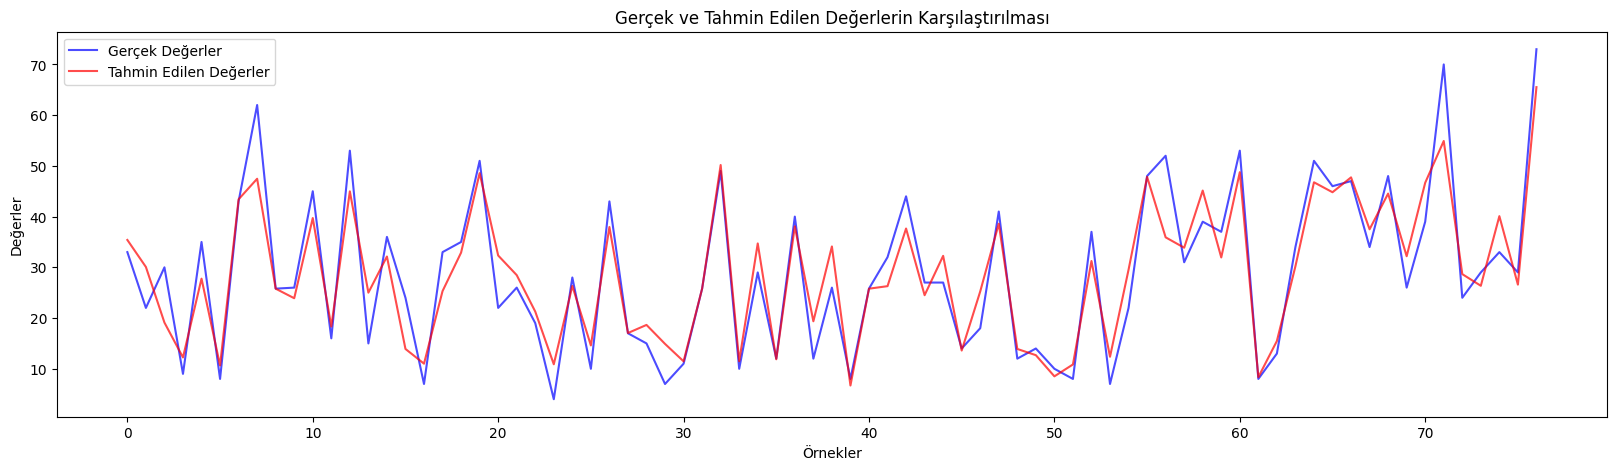

In [672]:
import matplotlib.pyplot as plt
import numpy as np

# Verinin %5'ini rastgele seçelim
sample_size = int(0.01 * len(y_val))  # %5 oranında veri al
indices = np.random.choice(len(y_val), size=sample_size, replace=False)

# NumPy dizilerini kullanarak örnekleri seç
y_test_sample = y_val.iloc[indices]
y_pred_sample = y_pred_val[indices]

plt.figure(figsize=(20, 5))

# Gerçek değerler (mavi çizgi)
plt.plot(y_test_sample.values, label='Gerçek Değerler', color='blue', alpha=0.7)

# Tahmin edilen değerler (kırmızı nokta)
plt.plot(y_pred_sample, label='Tahmin Edilen Değerler', color='red', alpha=0.7)

# Başlık ve etiketler
plt.title('Gerçek ve Tahmin Edilen Değerlerin Karşılaştırılması')
plt.xlabel('Örnekler')
plt.ylabel('Değerler')

# Grafik üzerindeki etiketleri göster
plt.legend()

# Grafiği gösterme
plt.show()


In [673]:

X_test_data = test_data
y_pred2 = model.predict(X_test_data)

test_data["Degerlendirme Puani"]=y_pred2
df=test_data[["Degerlendirme Puani"]]
df=df.reset_index()
df["id"]=df["index"]
df=df[["id","Degerlendirme Puani"]]
#df.to_csv("ati2.csv", index=False)

In [674]:
df["Degerlendirme Puani"].mean()

31.14768946795486

In [675]:
df["Degerlendirme Puani"].min()

0.4626178332738142

In [696]:
df1=pd.read_csv("cbnlpsiz20.csv")
df2=pd.read_csv("ati1.csv")
df3=pd.read_csv("cbnlpsiz8.csv")
df4=pd.read_csv("cbnlpsiz19.csv")
df5=pd.read_csv("cbnlpsiz10.csv")

In [697]:
(df1["Degerlendirme Puani"]-df2["Degerlendirme Puani"]).sum()

987.1534414330156

In [698]:
(df4["Degerlendirme Puani"]-df2["Degerlendirme Puani"]).sum()

1605.9918897133675

In [699]:
rmse_val2 = np.sqrt(mean_squared_error(df4["Degerlendirme Puani"], df2["Degerlendirme Puani"]))
print(f"Validation Seti RMSE: {rmse_val2}")
rmse_val2 = np.sqrt(mean_squared_error(df1["Degerlendirme Puani"], df2["Degerlendirme Puani"]))
print(f"Validation Seti RMSE: {rmse_val2}")

Validation Seti RMSE: 0.8678648149474851
Validation Seti RMSE: 0.827925909301101


In [ ]:
618.838448280352
Validation Seti RMSE: 0.3157760821519167